In [1]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.nonparametric.smoothers_lowess import lowess

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict

%load_ext autoreload
%autoreload 2

In [2]:
ylim_dict = {'snap' : [0,3], 'ssrs': [0,2], 'masc' : [0,3], 'pc': [0,4]}

In [3]:
trtnames = ['M', 'P', 'C']
timepoints = [0,90,270, 420]
delta = 50
timepoints_range = [[time - delta, time + delta] for time in timepoints]
timepoints_range
y_lim = [0,3]
x_lim = [-10, 450]

In [4]:
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')

In [5]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

In [6]:
snap = pd.read_csv(Path(data_derived, 'snap_14_and_mediators.csv'))
ssrs = pd.read_csv(Path(data_derived, 'ssrs_14_and_mediators.csv'))
masc = pd.read_csv(Path(data_derived, 'masc_14_and_mediators.csv'))
pc = pd.read_csv(Path(data_derived, 'pc_14_and_mediators.csv'))
qsts =['snap', 'ssrs', 'masc', 'pc']
data_dict = dict(zip(['snap', 'ssrs', 'masc', 'pc'], [snap, ssrs, masc, pc]))

In [7]:
#remove subjects from the 'assessemnt' period (before baseline)
for key, df in data_dict.items():
    data_dict[key] = df[(df['trtname'] != 'A') & (df['days_baseline']>=0)].copy() 



In [8]:
interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group

# mediator variables
comorb_mediators  = ['cdorodd' , 'pso', 'psoi', 'pag', 'pagi', 'pga', 'pgai' ,'psa'] #ODD/CD or anx excluding specific phobia 
services_mediators =  ['demo61'] #reciept of public assistance 
prev_med_mediators = ['hi_24'] #medication intake prior to study 

#moderator variables #
#accept_moderator = ['d2dresp'] # initail acceptance of treatment 
accept_moderator = ['d2dresp'] # initail acceptance of treatment # binary
raters = ['Teacher', 'Parent']

med_mod_list = np.concatenate([[comorb_mediators[0]], ['anx'], services_mediators, prev_med_mediators, accept_moderator, ['sex']])
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [9]:
#outcome variablles 
snap_vars = ['snainatx', 'snahypax', 'snaoddx'] #inattention_mean, hyperactie mean
ssrs_vars = ['sspintx', 'ssptossx']# social skills mean, internalizing mean 
masc_vars = ['masc_masctotalt']
pc_vars = ['pcrcpax', 'pcrcprx'] # power assertion, personal closeness
#wechsler_vars = ['w1readb','w2math','w3spell' ]
outcomes = np.concatenate([snap_vars, ssrs_vars, masc_vars, pc_vars])

outcomes_dict  = {'snap' : snap_vars, 'ssrs' : ssrs_vars, 'masc': masc_vars, 'pc': pc_vars}#, 'wechsler': wechsler_vars}

In [10]:
#outcome variables 
outcomes_written = ['SNAP Inattention', 'SNAP Hyperactivity', 'SNAP Aggressive','SSRS Internalizing', 'SSRS Social Skills', 'MASC total Score', 'Parent-Child Power Assertion', 'Parent-Child Personal Closeness' ]
outcomes_dict_fig = dict(zip(outcomes, outcomes_written))
outcomes_dict_fig

# treatment names 
trt_dict = {'M': 'Medication Management', 'P': 'Behavioral Treatment', 'C': 'Combined Treatment'}

#mediators 
med_written = ['CD or ODD', 'Anxiety', 'Public Assistance', 'Prior Medication', 'Initial Acceptance of Treatment Arm', 'Sex']
med_options = [['No', ''],['No', ''] ,['No', ''],['No', ''], ['Low', 'High'], ['Male', 'Female']]

# mediator variable names spelled out 
med_dict_fig = {} #for figure titles 
options_dict = {}
for i, med in enumerate(med_mod_list):
    med_dict_fig[med] = [med_options[i][j] + ' ' + med_written[i] for j in range(2)]
med_dict_fig

# outcome values for mediators and moderators 
values_possible = [[0,1],[0,1],[1,2],[1,2],[1,2,3,4,5,6] ,['M', 'F']]
values_possible

med_values = dict(zip(med_mod_list, values_possible))
med_values

{'cdorodd': [0, 1],
 'anx': [0, 1],
 'demo61': [1, 2],
 'hi_24': [1, 2],
 'd2dresp': [1, 2, 3, 4, 5, 6],
 'sex': ['M', 'F']}

In [166]:
gen_interact_formula = ' days_baseline + C(site) +C(trtname, Treatment(reference=None))' #

In [167]:
#include mediators and moderator as main effect and in interaction 
gen_med_formulas = [ gen_interact_formula +' * '+  str(med) for med in med_mod_list]
gen_med_formulas

formulas =  [[[' ~ '.join((var, gen_med_form)) for var in values] for gen_med_form in gen_med_formulas] for values in outcomes_dict.values()] 
formulas_dict = dict(zip(outcomes_dict.keys(), formulas))
formulas_dict

{'snap': [['snainatx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * cdorodd',
   'snahypax ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * cdorodd',
   'snaoddx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * anx',
   'snahypax ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * anx',
   'snaoddx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * anx'],
  ['snainatx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * demo61',
   'snahypax ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * demo61',
   'snaoddx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * demo61'],
  ['snainatx ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * hi_24',
   'snahypax ~  days_baseline + C(site) +C(trtname, Treatment(reference=None)) * hi_24',
   'snaodd

In [168]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

### Hypotheses for interaction -- mediator with treatement effect 

In [13]:
groups = 'src_subject_id'
alpha = 0.05
raters = ['Teacher', 'Parent']

In [14]:
for qst in data_dict.keys():
    print((qst))
    print((data_dict[qst]['days_baseline'].value_counts() < 0).sum())
    print('L', (data_dict[qst][ (data_dict[qst]['trtname'] == 'L') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('M', (data_dict[qst][ (data_dict[qst]['trtname'] == 'M') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('P', (data_dict[qst][ (data_dict[qst]['trtname'] == 'P') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('C', (data_dict[qst][ (data_dict[qst]['trtname'] == 'C') &(data_dict[qst]['days_baseline'] >=0)].shape))
    print('A', (data_dict[qst][ (data_dict[qst]['trtname'] == 'A') &(data_dict[qst]['days_baseline'] >=0)].shape))
    

snap
0
L (0, 17)
M (977, 17)
P (1118, 17)
C (1135, 17)
A (0, 17)
ssrs
0
L (0, 16)
M (988, 16)
P (1114, 16)
C (1135, 16)
A (0, 16)
masc
0
L (0, 14)
M (333, 14)
P (382, 14)
C (372, 14)
A (0, 14)
pc
0
L (0, 15)
M (1211, 15)
P (1359, 15)
C (1382, 15)
A (0, 15)


## RR analzsis

In [170]:
#for snap and ssrs, teacher and parent rater separated 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_s = {}
for i, qst in enumerate(['snap', 'ssrs']) :

    results_rater = {}
    for rater in raters: 
        results_ = {}
        
        for j, med in enumerate(med_mod_list):
            
            for k, var in enumerate(outcomes_dict[qst]):
                cols_total = np.concatenate([cols, [med, var]])
                print(cols_total)
                formula = formulas[i][j][k]
                data = data_dict[qst][(data_dict[qst]['version_form'] == rater) & (data_dict[qst][cols_total].notna().all(axis=1))]
                print(data.shape)
                groups = data['src_subject_id']
                result = smf.mixedlm(formula, data, groups = groups).fit()
                results_[str(med) + '_' + str(var) ] = result
                
        results_rater[rater] = results_
        
    results_s[qst] = results_rater

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1122, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1122, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1122, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(1141, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(1141, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
(1141, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snainatx']
(1071, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snahypax']
(1071, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snaoddx']
(1071, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snainatx']
(151, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snahypax']
(151, 53)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snaoddx']
(151, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snainatx']
(953, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snahypax']
(953, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snaoddx']
(953, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snainatx']
(1159, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snahypax']
(1159, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'snaoddx']
(1159, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
(1983, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
(1983, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
(1983, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
(2038, 53)
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
(2038, 53)
['src_subject_id' 'day

In [171]:
# for masc and pc, no rater 

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results_m = {}
for i, qst in enumerate(['masc', 'pc']) :
    results_ = {}
    for j, med in enumerate(med_mod_list):

        for k, var in enumerate(outcomes_dict[qst]):
            cols_total = np.concatenate([cols, [med, var]])
            print(cols_total)
            formula = formulas[i+2][j][k]
            data = data_dict[qst][cols_total].dropna()
            groups = data['src_subject_id']
            result = smf.mixedlm(formula, data, groups = groups).fit()
            results_[str(med) + '_' + str(var) ] = result
    results_m[qst] = results_
            

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp'
 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'sex' 'masc_masctotalt']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcpax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'pcrcprx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'h

In [172]:
results = {'snap': results_s['snap'], 'ssrs' : results_s['ssrs'], 'masc': results_m['masc'], 'pc': results_m['pc'] }

In [177]:
results["masc"].keys()

dict_keys(['cdorodd_masc_masctotalt', 'anx_masc_masctotalt', 'demo61_masc_masctotalt', 'hi_24_masc_masctotalt', 'd2dresp_masc_masctotalt', 'sex_masc_masctotalt'])

In [178]:
results['masc']['cdorodd_masc_masctotalt'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                         MixedLM            Dependent Variable:            masc_masctotalt
No. Observations:              1050               Method:                        REML           
No. Groups:                    360                Scale:                         780.3427       
Min. group size:               1                  Log-Likelihood:                -5062.2579     
Max. group size:               4                  Converged:                     Yes            
Mean group size:               2.9                                                              
------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------------
Intercept                                          105.106    3.748 28.045 0.000  97.760 112.451
C(site)[T.2]                                         9.729    4.084  2.382 0.017   1.724  17.734
C(site)[T.3]                                         5.702    4.117  1.385 0.166  -2.368  13.771
C(site)[T.4]                                         4.465    3.989  1.119 0.263  -3.354  12.284
C(site)[T.5]                                        -3.137    3.934 -0.798 0.425 -10.847   4.572
C(site)[T.6]                                         1.683    4.050  0.416 0.678  -6.255   9.621
C(trtname, Treatment(reference=None))[T.M]          -5.473    3.620 -1.512 0.131 -12.569   1.623
C(trtname, Treatment(reference=None))[T.P]          -3.252    3.640 -0.893 0.372 -10.386   3.882
days_baseline                                       -0.016    0.005 -3.150 0.002  -0.026  -0.006
cdorodd                                              0.712    4.059  0.176 0.861  -7.243   8.668
C(trtname, Treatment(reference=None))[T.M]:cdorodd   4.763    5.897  0.808 0.419  -6.794  16.320
C(trtname, Treatment(reference=None))[T.P]:cdorodd  -0.329    5.718 -0.058 0.954 -11.536  10.878
Group Var                                          200.265    1.559                             
================================================================================================

"""

In [191]:
hyps_trtnames_list = [ "C(trtname, Treatment(reference=None))[T.P]", "C(trtname, Treatment(reference=None))[T.M]"]
sex_hyp = ['C(trtname, Treatment(reference=None))[T.P]:sex[T.M] = 0' , 'C(trtname, Treatment(reference=None))[T.M]:sex[T.M] = 0']
hyps = [[(hyps_trtname + ":" + mediator + " = 0") for hyps_trtname in hyps_trtnames_list] for mediator in med_mod_list[:-1]]
hyps.append(sex_hyp)
hyps_dict = dict(zip(med_mod_list, hyps))
hyps_dict

{'cdorodd': ['C(trtname, Treatment(reference=None))[T.P]:cdorodd = 0',
  'C(trtname, Treatment(reference=None))[T.M]:cdorodd = 0'],
 'anx': ['C(trtname, Treatment(reference=None))[T.P]:anx = 0',
  'C(trtname, Treatment(reference=None))[T.M]:anx = 0'],
 'demo61': ['C(trtname, Treatment(reference=None))[T.P]:demo61 = 0',
  'C(trtname, Treatment(reference=None))[T.M]:demo61 = 0'],
 'hi_24': ['C(trtname, Treatment(reference=None))[T.P]:hi_24 = 0',
  'C(trtname, Treatment(reference=None))[T.M]:hi_24 = 0'],
 'd2dresp': ['C(trtname, Treatment(reference=None))[T.P]:d2dresp = 0',
  'C(trtname, Treatment(reference=None))[T.M]:d2dresp = 0'],
 'sex': ['C(trtname, Treatment(reference=None))[T.P]:sex[T.M] = 0',
  'C(trtname, Treatment(reference=None))[T.M]:sex[T.M] = 0']}

In [192]:
def split_on_occurrence(s, char, occurrence=1):
    if occurrence == 1:
        # Find the index of the first occurrence of the character
        index = s.find(char)
    elif occurrence == 2:
        # Find the index of the second occurrence of the character
        first_occurrence = s.find(char)
        index = s.find(char, first_occurrence + 1)
    else:
        raise ValueError("Occurrence must be 1 or 2")

    # If the occurrence is found, split the string
    if index != -1:
        return s[:index], s[index+1:]
    else:
        # If the occurrence isn't found, return the original string
        return s, ''

In [193]:
data_dict['snap']

,Unnamed: 0,src_subject_id,interview_date,interview_age,sex,snainatx,snahypax,snaoddx,days_baseline,site,...,predicted_demo61_snaoddx_P,predicted_hi_24_snainatx_P,predicted_hi_24_snahypax_P,predicted_hi_24_snaoddx_P,predicted_d2dresp_snainatx_P,predicted_d2dresp_snahypax_P,predicted_d2dresp_snaoddx_P,predicted_sex_snainatx_P,predicted_sex_snahypax_P,predicted_sex_snaoddx_P
1,1,P1002,1997-06-03,120,M,1.00,0.50,1.25,0,1,...,NaN,1.549619,1.517944,1.101071,NaN,NaN,NaN,1.584993,1.454897,1.249796
2,2,P1002,1997-06-03,120,M,1.11,1.00,0.88,0,1,...,NaN,1.549619,1.517944,1.101071,NaN,NaN,NaN,1.584993,1.454897,1.249796
3,3,P1002,1997-09-19,124,M,0.33,0.33,0.63,108,1,...,NaN,1.362382,1.308008,1.002683,NaN,NaN,NaN,1.413384,1.250712,1.137492
4,4,P1002,1998-01-03,127,M,0.44,0.17,0.13,214,1,...,NaN,1.178612,1.101961,0.906117,NaN,NaN,NaN,1.244953,1.050309,1.027267
5,5,P1002,1998-01-13,127,M,0.67,0.50,0.75,224,1,...,NaN,1.161275,1.082522,0.897007,NaN,NaN,NaN,1.229063,1.031403,1.016869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,5228,P1839,1995-05-23,75,M,0.44,0.83,1.13,99,4,...,1.182861,NaN,NaN,NaN,1.551131,1.486925,1.187039,1.551827,1.465468,1.177140
5229,5229,P1839,1995-10-25,80,M,0.33,0.17,0.63,254,4,...,1.020262,NaN,NaN,NaN,1.298278,1.192877,1.021157,1.305537,1.172426,1.015963
5230,5230,P1839,1996-06-02,88,M,0.33,0.50,0.50,475,4,...,0.788427,NaN,NaN,NaN,0.937759,0.773622,0.784642,0.954374,0.754604,0.786155
5232,5232,P1842,1995-02-21,72,M,2.78,2.17,0.57,0,4,...,1.424456,NaN,NaN,NaN,1.863085,1.692508,1.445009,1.808656,1.646810,1.425483


In [194]:
results['snap']['Teacher']['cdorodd_snainatx']

### TEST interaction 

In [195]:
hyps_dict


{'cdorodd': ['C(trtname, Treatment(reference=None))[T.P]:cdorodd = 0',
  'C(trtname, Treatment(reference=None))[T.M]:cdorodd = 0'],
 'anx': ['C(trtname, Treatment(reference=None))[T.P]:anx = 0',
  'C(trtname, Treatment(reference=None))[T.M]:anx = 0'],
 'demo61': ['C(trtname, Treatment(reference=None))[T.P]:demo61 = 0',
  'C(trtname, Treatment(reference=None))[T.M]:demo61 = 0'],
 'hi_24': ['C(trtname, Treatment(reference=None))[T.P]:hi_24 = 0',
  'C(trtname, Treatment(reference=None))[T.M]:hi_24 = 0'],
 'd2dresp': ['C(trtname, Treatment(reference=None))[T.P]:d2dresp = 0',
  'C(trtname, Treatment(reference=None))[T.M]:d2dresp = 0'],
 'sex': ['C(trtname, Treatment(reference=None))[T.P]:sex[T.M] = 0',
  'C(trtname, Treatment(reference=None))[T.M]:sex[T.M] = 0']}

In [196]:
results['snap']['Teacher']['anx_snahypax'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM            Dependent Variable:            snahypax  
No. Observations:             1141               Method:                        REML      
No. Groups:                   360                Scale:                         0.4377    
Min. group size:              1                  Log-Likelihood:                -1269.5319
Max. group size:              5                  Converged:                     Yes       
Mean group size:              3.2                                                         
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       1.627    0.085  19.211 0.000  1.461  1.792
C(site)[T.2]                                    0.133    0.100   1.333 0.183 -0.062  0.328
C(site)[T.3]                                    0.179    0.095   1.878 0.060 -0.008  0.365
C(site)[T.4]                                    0.033    0.088   0.380 0.704 -0.139  0.205
C(site)[T.5]                                   -0.064    0.089  -0.725 0.469 -0.238  0.109
C(site)[T.6]                                   -0.115    0.090  -1.276 0.202 -0.292  0.062
C(trtname, Treatment(reference=None))[T.M]      0.113    0.081   1.406 0.160 -0.045  0.271
C(trtname, Treatment(reference=None))[T.P]      0.310    0.077   4.005 0.000  0.158  0.462
days_baseline                                  -0.003    0.000 -21.815 0.000 -0.003 -0.002
anx                                            -0.162    0.095  -1.699 0.089 -0.348  0.025
C(trtname, Treatment(reference=None))[T.M]:anx -0.079    0.138  -0.574 0.566 -0.350  0.192
C(trtname, Treatment(reference=None))[T.P]:anx  0.114    0.134   0.854 0.393 -0.148  0.377
Group Var                                       0.105    0.034                            
==========================================================================================

"""

In [197]:
sig_results=[]
for qst in ['snap', "ssrs"]:
    for rater in raters:
        for key in results[qst][rater]:
            splitt = key.split("_")
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
            else:
                var_mod = splitt[0]
            hyp = hyps_dict[var_mod]
            f_test_r = results[qst][rater][key].f_test(hyp)
            if f_test_r.pvalue < 0.05:
                print("SIGNIFICANT")
                sig_results.append({key:results[qst][rater][key]})
            print(key, hyp, f_test_r.pvalue)

cdorodd_snainatx ['C(trtname, Treatment(reference=None))[T.P]:cdorodd = 0', 'C(trtname, Treatment(reference=None))[T.M]:cdorodd = 0'] 0.7746288727952484
cdorodd_snahypax ['C(trtname, Treatment(reference=None))[T.P]:cdorodd = 0', 'C(trtname, Treatment(reference=None))[T.M]:cdorodd = 0'] 0.49794934287680337
cdorodd_snaoddx ['C(trtname, Treatment(reference=None))[T.P]:cdorodd = 0', 'C(trtname, Treatment(reference=None))[T.M]:cdorodd = 0'] 0.17879616586062128
anx_snainatx ['C(trtname, Treatment(reference=None))[T.P]:anx = 0', 'C(trtname, Treatment(reference=None))[T.M]:anx = 0'] 0.4867350640501503
anx_snahypax ['C(trtname, Treatment(reference=None))[T.P]:anx = 0', 'C(trtname, Treatment(reference=None))[T.M]:anx = 0'] 0.36301118123617204
anx_snaoddx ['C(trtname, Treatment(reference=None))[T.P]:anx = 0', 'C(trtname, Treatment(reference=None))[T.M]:anx = 0'] 0.881075885448535
demo61_snainatx ['C(trtname, Treatment(reference=None))[T.P]:demo61 = 0', 'C(trtname, Treatment(reference=None))[T.M]:

In [165]:
sig_vars = []
for result in sig_results:
    sig_vars.append(result.keys())
    
sig_vars

[dict_keys(['demo61_snainatx']),
 dict_keys(['cdorodd_ssptossx']),
 dict_keys(['anx_ssptossx'])]

In [146]:
results["snap"].keys()

dict_keys(['Teacher', 'Parent'])

In [144]:
f_test_result = results['snap']['Teacher']['sex_snahypax'].f_test(hyps_dict['sex'])
p_value = f_test_result.pvalue 
f_value = f_test_result.fvalue 

significance = "*Significant*" if p_value < 0.05 else "Not Significant"
p_value



0.2828737249460342

## SMOOTH

In [21]:
trtnames = ['M', 'P', 'C']

In [22]:
def get_rolling_av(subset, pred_col_name, window):
    subset_sorted = subset.sort_values('days_baseline')
# Apply rolling mean across the 'days_baseline'
    smoothed = subset_sorted[pred_col_name].rolling(window=window, min_periods=1).mean()

    # Ensure the rolling mean values are aligned with the sorted 'days_baseline'
    smoothed_df = pd.DataFrame({
        'days_baseline': subset_sorted['days_baseline'],
        'smoothed_value': smoothed
    })
    return smoothed_df

def extract_prediction(results, data_dict, to_plot):
    # extract predicted datapoints for all questionnaires
    for qst in to_plot:
        if qst == 'snap' or qst == 'ssrs':
            print(qst.upper())
            for rater in raters:
                for var_result in results[qst][rater].keys():    
                    result = results[qst][rater][var_result]
                    #print(result)
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' +  str(var_result) +'_' + str(rater[0])] = result.predict(data) #
                    
        elif qst == 'masc' or qst == 'pc':    
            print(qst.upper())       
            for var_result in results[qst].keys():
                data = data_dict[qst]
                result = results[qst][var_result]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) 
                
                
def get_point_av(df, pred_col_name, timepoints_range):
    df.sort_values('days_baseline')
    subset = df[['days_baseline', pred_col_name]]
    point_av = np.array([ subset[subset['days_baseline'].isin(range(range_t[0], range_t[1]))].mean(axis = 0) for range_t in timepoints_range])
    return point_av 


def get_timepoints_range(timepoints, delta):
    return  [[time - delta, time + delta] for time in timepoints]


def extract_line_plot(df, pred_col_name, type_plot, pnt_av = None,  window = None):
    
    timepoints_range = get_timepoints_range(timepoints, delta)
    ptn_av = get_point_av(df,pred_col_name, timepoints_range )
    
    subset = df.dropna(subset=pred_col_name)
    subset_sorted = subset.sort_values('days_baseline')
    print(subset_sorted[pred_col_name].isna().sum())
    print("SHAPE subset:", subset[pred_col_name].dropna().shape, "SHAPE subset sorted", subset_sorted[pred_col_name].dropna().shape, )
    #lowess smoothing function 
    if type_plot == "smooth":
        print('type smoothed')
        print(subset_sorted[pred_col_name].shape, subset_sorted['days_baseline'].shape)
        smoothed = lowess(subset_sorted[pred_col_name], subset_sorted['days_baseline'], frac=0.1)
        print(smoothed.shape)
        smoothed_df = pd.DataFrame({
        'days_baseline': smoothed[:,0],
        'smoothed_value': smoothed[:,1]
    })

        
    elif type_plot == "mov_av":
        print('type moving average')
        #moving average with size window
        smoothed_df = get_rolling_av(subset_sorted, pred_col_name, window)

    
    elif type_plot == 'poly_fit':
        print('type four point polynomial fit')
        # polynomial fit to average datapoints 
        
        if len(pnt_av) > 2 and len(pnt_av) > 2:
            
            x_fit_min = min(pnt_av[:, 0].min(), pnt_av[:, 0].min())
            x_fit_max = max(pnt_av[:, 0].max(), pnt_av[:, 0].max())
            x_fit = np.linspace(x_fit_min, x_fit_max, 100)
            
            try:
                # Polynomial fit 
                poly_fit = np.polyfit(pnt_av[:, 0], pnt_av[:, 1], 2)
                poly_function_yes = np.poly1d(poly_fit)
                smoothed = poly_function_yes(x_fit)
                print(smoothed.shape, pnt_av.shape)
                smoothed_df = pd.DataFrame({
                    'days_baseline': x_fit,
                    'smoothed_value': smoothed
            })
                
                
            except np.linalg.LinAlgError:
                print("Polynomial fit for 'no' failed due to singular matrix")
                return
                
           
        else:
            print("Not enough points for polynomial fit in treatment group:")   
            return
    else:
        print("Plot type not recognized.")
        return
    print("SMOOTHED shape", smoothed_df.shape)
    return smoothed_df
        

            
            
        
        

In [23]:
med_dict_fig

{'cdorodd': ['No CD or ODD', ' CD or ODD'],
 'anx': ['No Anxiety', ' Anxiety'],
 'demo61': ['No Public Assistance', ' Public Assistance'],
 'hi_24': ['No Prior Medication', ' Prior Medication'],
 'd2dresp': ['Low Initial Acceptance of Treatment Arm',
  'High Initial Acceptance of Treatment Arm'],
 'sex': ['Male Sex', 'Female Sex']}

In [24]:
def plot_RR_results(data, var_mod, var_out, med_values, type_plot, window, timepoints_range, trt_dict , rater = None, xlim= [0,3], ylim= [-10,450], show = True, save_path= None):
    pred_col_name= 'predicted_' + var_mod + '_' + var_out

    trtnames = data['trtname'].unique()
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    
    type_plot_dict ={"poly_fit": "Polyniomial fit on four point average, degree 2", 
                 "mov_av": "Moving average on predicted score, window = {}".format(window),
                 "smooth": "Smoothed Predicted Score"}
    
    
    values = med_values[var_mod]
    print(values)
    # Create subplots: 2 rows (1st row for polynomial fit, 2nd row for bar plot)
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]
        
    print("YES MOD: ", yes_mod.shape)
    print("NO MOD :", no_mod.shape)
        
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
        pred_col_name = pred_col_name +'_' +str(rater[0])

    # Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
    for trt in trtnames:
        
        df_yes = yes_mod[yes_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        df_no = no_mod[no_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        print("DF per TRT: ",trt, df_yes.shape, df_no.shape)
        
        point_av_yes = get_point_av(df_yes, pred_col_name, timepoints_range)
        point_av_no = get_point_av(df_no, pred_col_name, timepoints_range)
        print("PTN AV: ", point_av_yes, point_av_no)
        
        line_yes = extract_line_plot(df_yes, pred_col_name, type_plot,point_av_yes, window)
        line_no = extract_line_plot(df_no, pred_col_name, type_plot,point_av_no, window)

        print("LINE YES, LINE NO smoothed value")
        print(line_yes['smoothed_value'].shape, line_no['smoothed_value'].shape)
        print("LINE YES, LINE NO days baseline ")
        print(line_yes['days_baseline'].shape, line_no['days_baseline'].shape)
        if line_yes is None or line_no is None :
            print('Computation has failed for {} : '.format(type_plot_dict[type_plot]) + str(pred_col_name))
            return 
        
        axes[0,0].plot(line_yes['days_baseline'],line_yes['smoothed_value'],  label= trt_dict[trt])
        axes[0,0].scatter(point_av_yes[:,0], point_av_yes[:,1])
        
        axes[0,1].plot(line_no['days_baseline'],line_no['smoothed_value'],  label= trt_dict[trt])
        axes[0,1].scatter(point_av_no[:,0], point_av_no[:,1])
        
        
    axes[0, 0].set_xlabel('Assessment point (d)')
    axes[0, 0].set_ylabel(type_plot_dict[type_plot])
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])
    # Add labels and titles to the subplots
    #axes[1, 0].set_title(title[1])
    #axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    #axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlabel('Assessment point (d)')
    axes[0, 1].set_ylabel('Fitted Predicted Score')
    axes[0, 1].legend()




    # Set xlim and ylim
    axes[0, 0].set_xlim(x_lim)
    axes[0, 1].set_xlim(x_lim)
    axes[1, 0].set_xlim(x_lim)
    axes[1, 1].set_xlim(x_lim)

    axes[0, 0].set_ylim(y_lim)
    axes[0, 1].set_ylim(y_lim)


    if type_plot == "ploy_fit":
        bins = timepoints  # Adjust the number of bins as needed

        #Bar plot for "No Anxiety"
        trt_groups_no = no_mod['trtname'].unique()
        counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

        # Initialize bottom for stacked bars
        bottom_no = np.zeros(len(bins)-1)

        # Plot the stacked bars for "No  mediator"
        for trt in trt_groups_no:
            counts = counts_by_trt_no[trt]
            axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
            bottom_no += counts  # Update bottom for the next treatment group

        # Bar plot for "Anxiety"
        trt_groups_yes = yes_mod['trtname'].unique()
        counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

        # Initialize bottom for stacked bars
        bottom_yes = np.zeros(len(bins)-1)


        # Plot the stacked bars for "Anxiety"
        for trt in trt_groups_yes:
            counts = counts_by_trt_yes[trt]
            axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
            bottom_yes += counts  # Update bottom for the next treatment group
            
    else: 
        bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
        trt_groups_no = no_mod['trtname'].unique()
        counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

        # Initialize bottom for stacked bars
        bottom_no = np.zeros(len(bins)-1)

        # Plot the stacked bars for "No  mediator"
        for trt in trt_groups_no:
            counts = counts_by_trt_no[trt]
            axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
            bottom_no += counts  # Update bottom for the next treatment group


        # Bar plot for "Anxiety"
        trt_groups_yes = yes_mod['trtname'].unique()
        counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

        # Initialize bottom for stacked bars
        bottom_yes = np.zeros(len(bins)-1)
        # Plot the stacked bars for "Anxiety"
        for trt in trt_groups_yes:
            counts = counts_by_trt_yes[trt]
            axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
            bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    if save_path is not None:
        folder_path = Path(save_path) / str(type_plot)
        folder_path.mkdir(exist_ok=True)
        fig_name = pred_col_name + '_' + str(rater[0]) + '.jpg' if rater is not None else pred_col_name + '.jpg'
        print(folder_path)
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        print(show)
        plt.tight_layout()
        plt.show()
        
    plt.close(fig)
        
        #axes[0, 0].scatter(point_av_yes[:, 0], point_av_yes[:, 1], label=trt_dict[trt])
        #axes[0, 0].plot(x_fit, y_fit_yes, linestyle='--', label=trt_dict[trt])
        
        

In [25]:
qsts

['snap', 'ssrs', 'masc', 'pc']

In [26]:
extract_prediction(results, data_dict, qsts)

SNAP
SSRS
MASC
PC


In [28]:
data_dict['ssrs'].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'days_baseline', 'site', 'version_form', 'ssptossx', 'sspintx',
       'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61', 'd2dresp',
       'predicted_cdorodd_sspintx_T', 'predicted_cdorodd_ssptossx_T',
       'predicted_anx_sspintx_T', 'predicted_anx_ssptossx_T',
       'predicted_demo61_sspintx_T', 'predicted_demo61_ssptossx_T',
       'predicted_hi_24_sspintx_T', 'predicted_hi_24_ssptossx_T',
       'predicted_d2dresp_sspintx_T', 'predicted_d2dresp_ssptossx_T',
       'predicted_sex_sspintx_T', 'predicted_sex_ssptossx_T',
       'predicted_cdorodd_sspintx_P', 'predicted_cdorodd_ssptossx_P',
       'predicted_anx_sspintx_P', 'predicted_anx_ssptossx_P',
       'predicted_demo61_sspintx_P', 'predicted_demo61_ssptossx_P',
       'predicted_hi_24_sspintx_P', 'predicted_hi_24_ssptossx_P',
       'predicted_d2dresp_sspintx_P', 'predicted_d2dresp_ssptossx_P',
       'predicted_sex_sspintx_P', 'predicted_sex

In [46]:
data = data_dict["ssrs"]
var_mod = 'cdorodd'
var_out = 'ssptossx'
plot = True
pred_col_name = 'predicted_cdorodd_ssptossx_T'
rater = "Parent"
window  = 50 
ylim = [0,3]
xlim = [-10,450]
type_plot = 'smooth' 
# options type plot : ploy_fit, mov_av, smooth 


pnt_av = get_point_av(data, pred_col_name, timepoints_range)


In [47]:
data_dict["pc"].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'days_baseline', 'site', 'pcrcpax', 'pcrcprx', 'trtname',
       'cdorodd', 'anx', 'hi_24', 'demo61', 'd2dresp',
       'predicted_cdorodd_pcrcpax', 'predicted_cdorodd_pcrcprx',
       'predicted_anx_pcrcpax', 'predicted_anx_pcrcprx',
       'predicted_demo61_pcrcpax', 'predicted_demo61_pcrcprx',
       'predicted_hi_24_pcrcpax', 'predicted_hi_24_pcrcprx',
       'predicted_d2dresp_pcrcpax', 'predicted_d2dresp_pcrcprx',
       'predicted_sex_pcrcpax', 'predicted_sex_pcrcprx'],
      dtype='object')

0
SHAPE subset: (3121,) SHAPE subset sorted (3121,)
type smoothed
(3121,) (3121,)
(3121, 2)
SMOOTHED shape (3121, 2)
[0, 1]
YES MOD:  (1189, 40)
NO MOD : (1814, 40)
DF per TRT:  C (420, 40) (617, 40)
PTN AV:  [[  0.           1.05536806]
 [ 98.42528736   1.08954014]
 [262.18644068   1.14790614]
 [414.2195122    1.18512725]] [[2.40837696e-01 1.09218371e+00]
 [9.53831776e+01 1.12547381e+00]
 [2.57120482e+02 1.18371835e+00]
 [4.12522727e+02 1.22494981e+00]]
0
SHAPE subset: (420,) SHAPE subset sorted (420,)
type smoothed
(420,) (420,)
(420, 2)
SMOOTHED shape (420, 2)
0
SHAPE subset: (617,) SHAPE subset sorted (617,)
type smoothed
(617,) (617,)
(617, 2)
SMOOTHED shape (617, 2)
LINE YES, LINE NO smoothed value
(420,) (617,)
LINE YES, LINE NO days baseline 
(420,) (617,)
DF per TRT:  M (338, 40) (601, 40)
PTN AV:  [[  0.           1.05985275]
 [ 96.92727273   1.10129048]
 [252.02083333   1.15758133]
 [410.31343284   1.19915868]] [[  0.           1.02627514]
 [ 97.05319149   1.06567256]
 [249.

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

True


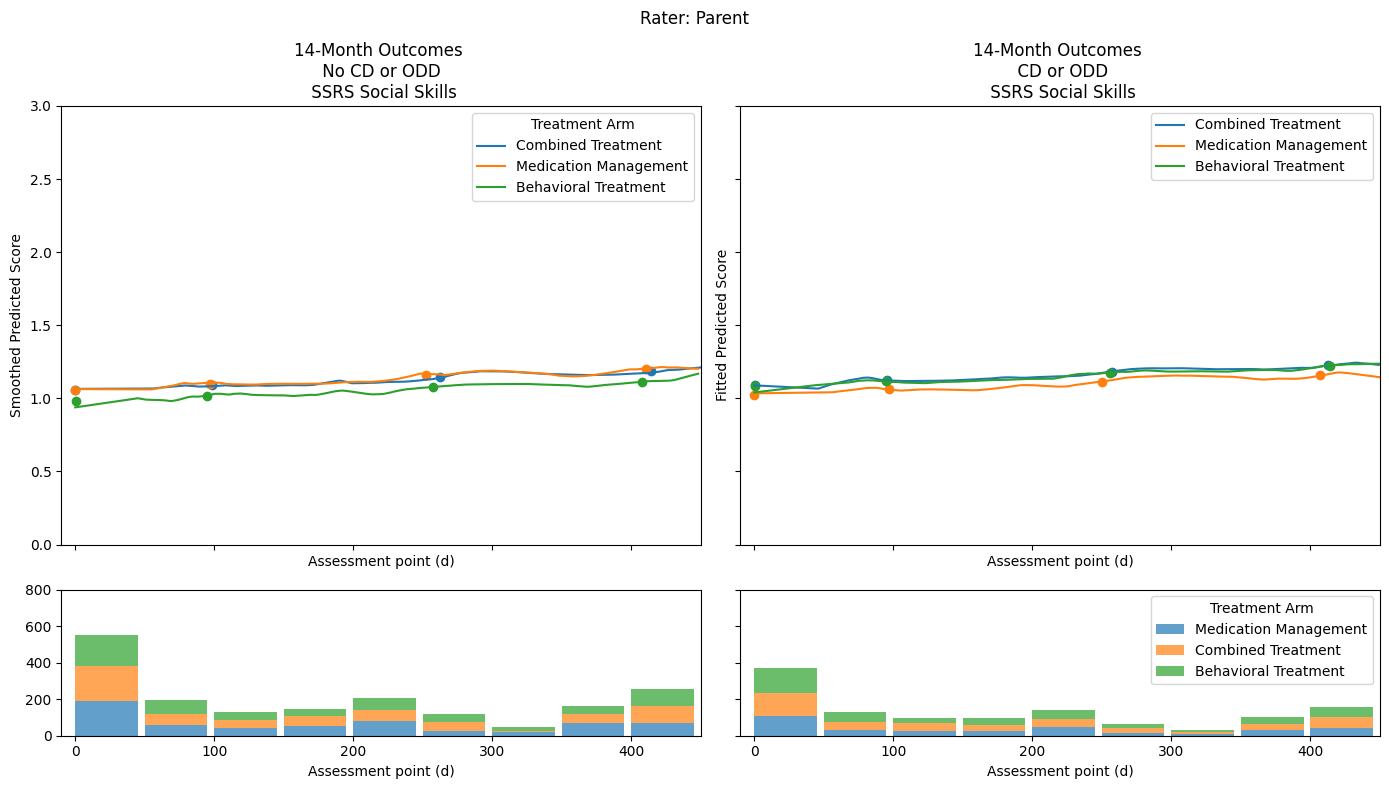

In [48]:
test = extract_line_plot(data, pred_col_name, type_plot=type_plot, pnt_av=pnt_av, window=window )    
plot_RR_results(data, var_mod, var_out, med_values, type_plot=type_plot, window= window, timepoints_range=timepoints_range, trt_dict=trt_dict, rater=rater, xlim=xlim, ylim=ylim, show = plot, save_path=save_path)

In [49]:
cols_replication = ['predicted_anx_snahypax_P','predicted_anx_snainatx_P' , 'predicted_demo61_ssptossx_T', 'predicted_demo61_pcrcprx','predicted_d2dresp_snainatx_P' ]

In [112]:
raters_dict_rev = {"P": "Parent", "T": "Teacher"}

['predicted', 'anx', 'snahypax', 'P']
anx snahypax Parent
[0, 1]
0
SHAPE subset: (340,) SHAPE subset sorted (340,)
type moving average
SMOOTHED shape (340, 2)
0
SHAPE subset: (737,) SHAPE subset sorted (737,)
type moving average
SMOOTHED shape (737, 2)
LINE YES, LINE NO
      days_baseline  smoothed_value
38                0        1.513003
5057              0        1.587901
211               0        1.631692
212               0        1.653587
2374              0        1.619577
...             ...             ...
3599            443        0.768035
592             443        0.761996
3638            444        0.758927
2949            447        0.760935
761             448        0.757909

[340 rows x 2 columns]       days_baseline  smoothed_value
1                 0        1.454469
3379              0        1.465428
3372              0        1.547660
3325              0        1.511730
3313              0        1.500278
...             ...             ...
4218            448  

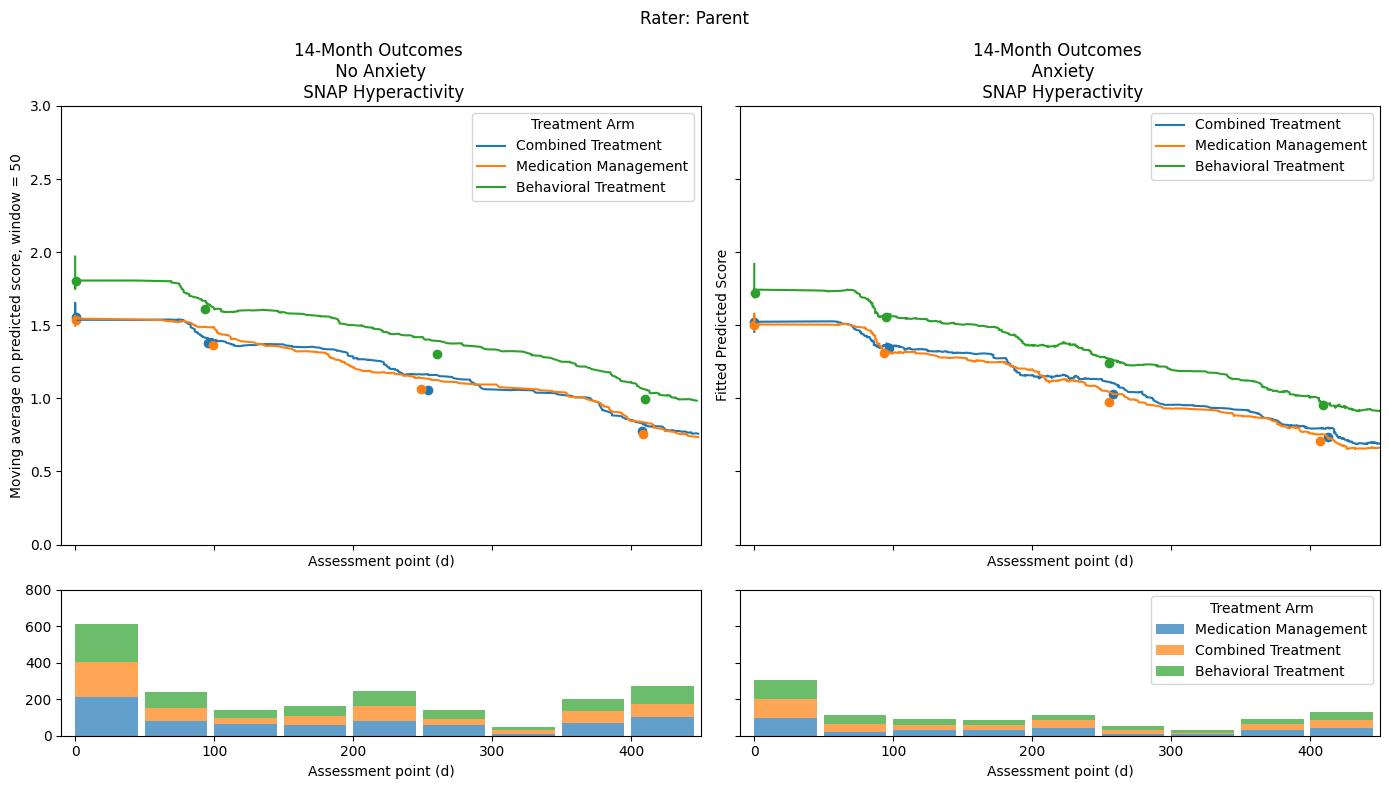

['predicted', 'anx', 'snainatx', 'P']
anx snainatx Parent
[0, 1]
0
SHAPE subset: (340,) SHAPE subset sorted (340,)
type moving average
SMOOTHED shape (340, 2)
0
SHAPE subset: (737,) SHAPE subset sorted (737,)
type moving average
SMOOTHED shape (737, 2)
LINE YES, LINE NO
      days_baseline  smoothed_value
38                0        1.657152
5057              0        1.683785
211               0        1.676505
212               0        1.672865
2374              0        1.634491
...             ...             ...
3599            443        0.949360
592             443        0.944973
3638            444        0.944307
2949            447        0.945294
761             448        0.942859

[340 rows x 2 columns]       days_baseline  smoothed_value
1                 0        1.579056
3379              0        1.531519
3372              0        1.575990
3325              0        1.567571
3313              0        1.569868
...             ...             ...
4218            448  

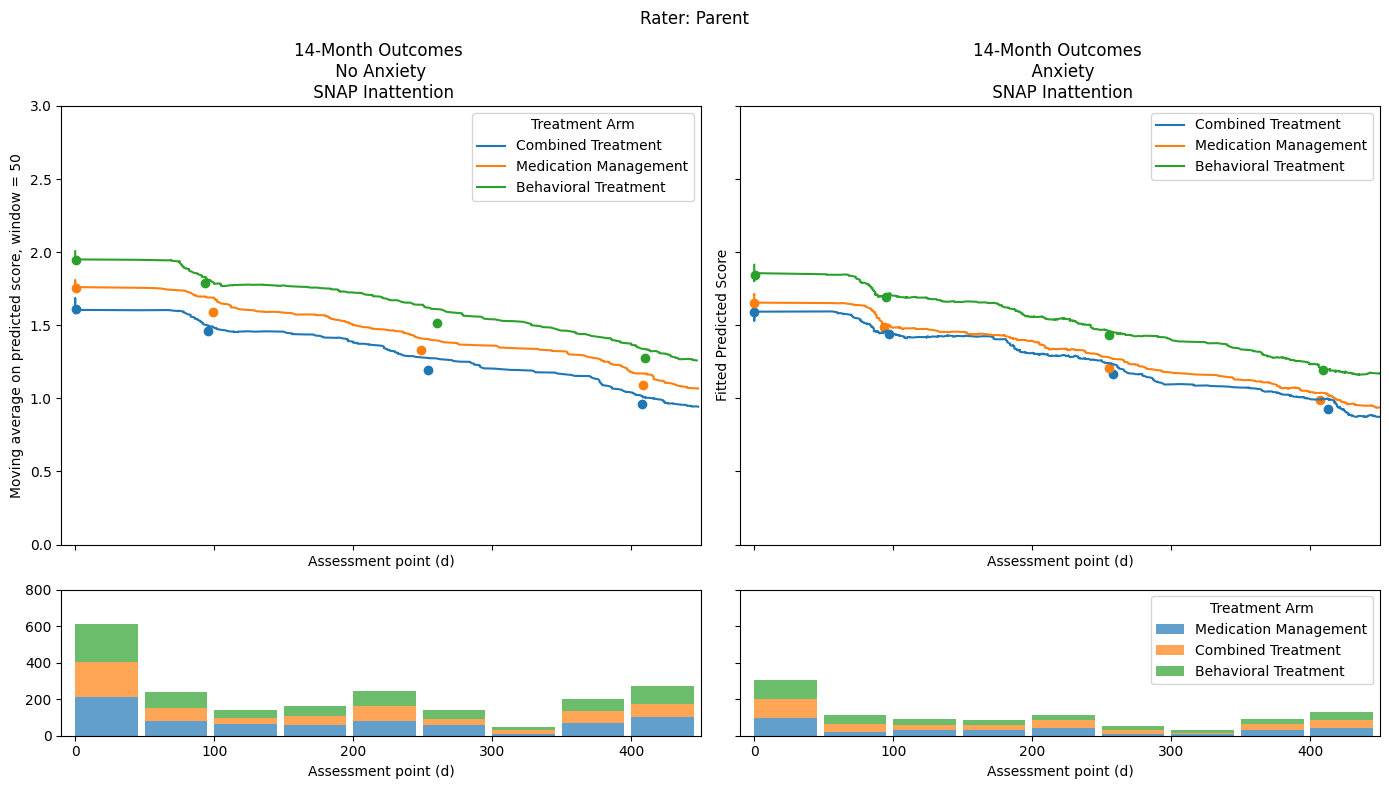

['predicted', 'demo61', 'ssptossx', 'T']
demo61 ssptossx Teacher
[1, 2]
0
SHAPE subset: (991,) SHAPE subset sorted (991,)
type moving average
SMOOTHED shape (991, 2)
0
SHAPE subset: (51,) SHAPE subset sorted (51,)
type moving average
SMOOTHED shape (51, 2)
LINE YES, LINE NO
      days_baseline  smoothed_value
33                0        0.936323
3133              0        0.936323
3119              0        0.939605
2865              0        0.936734
2644              0        0.947409
...             ...             ...
3484            448        1.258904
733             448        1.260039
1929            449        1.260113
1331            449        1.259991
4105            450        1.259037

[991 rows x 2 columns]       days_baseline  smoothed_value
233               0        0.801377
579               0        0.782563
3684              0        0.785553
687               0        0.786688
1090              0        0.787657
3068              0        0.783672
1701             

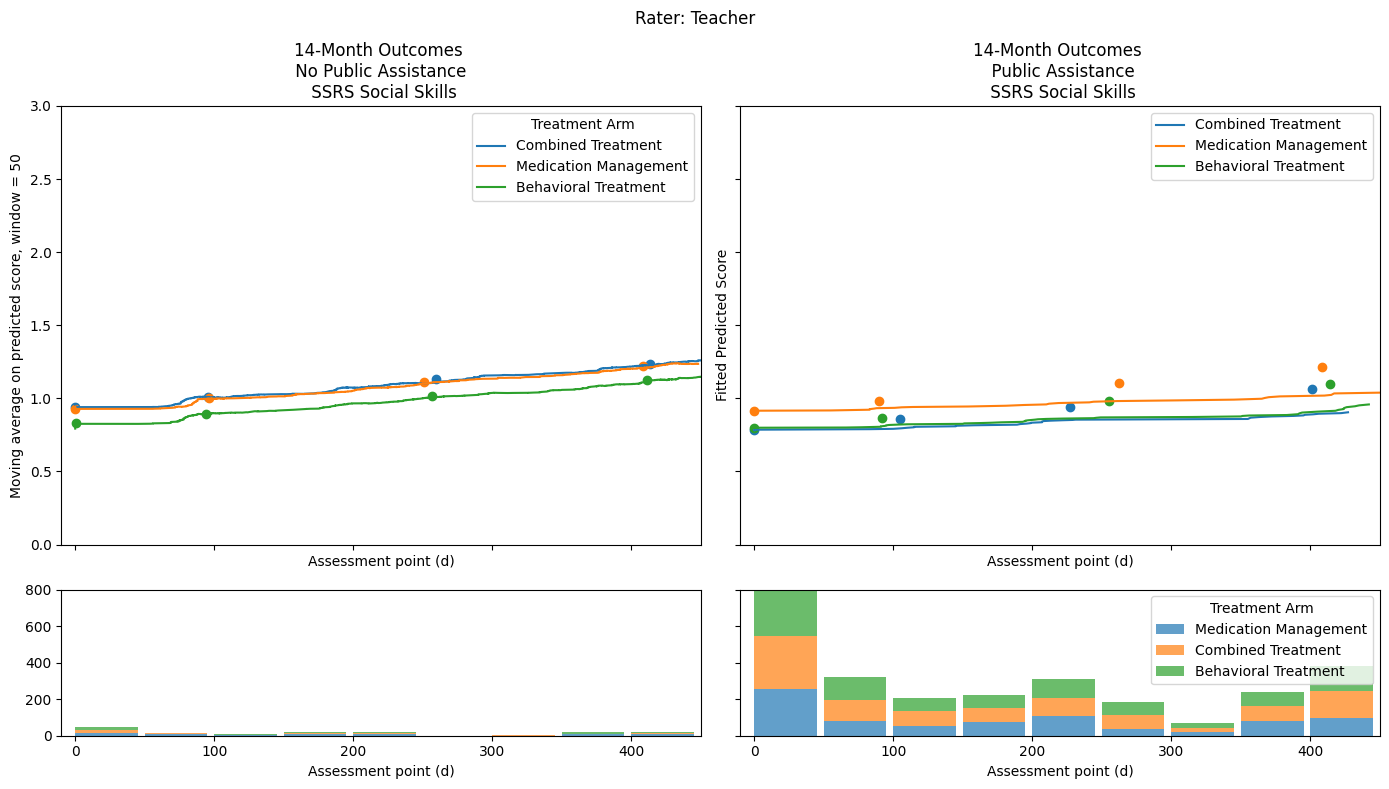

['predicted', 'demo61', 'pcrcprx']
demo61 pcrcprx None
[1, 2]
0
SHAPE subset: (1205,) SHAPE subset sorted (1205,)
type moving average
SMOOTHED shape (1205, 2)
0
SHAPE subset: (61,) SHAPE subset sorted (61,)
type moving average
SMOOTHED shape (61, 2)
LINE YES, LINE NO
      days_baseline  smoothed_value
60                0        3.617912
4529              0        3.624817
4518              0        3.622516
4517              0        3.621365
68                0        3.620674
...             ...             ...
2592            448        3.574146
2585            448        3.571474
4031            449        3.568803
4030            449        3.566132
4999            449        3.566145

[1205 rows x 2 columns]       days_baseline  smoothed_value
444               0        3.508041
448               0        3.508041
447               0        3.508041
4679              0        3.503633
1094              0        3.529021
...             ...             ...
451             422    

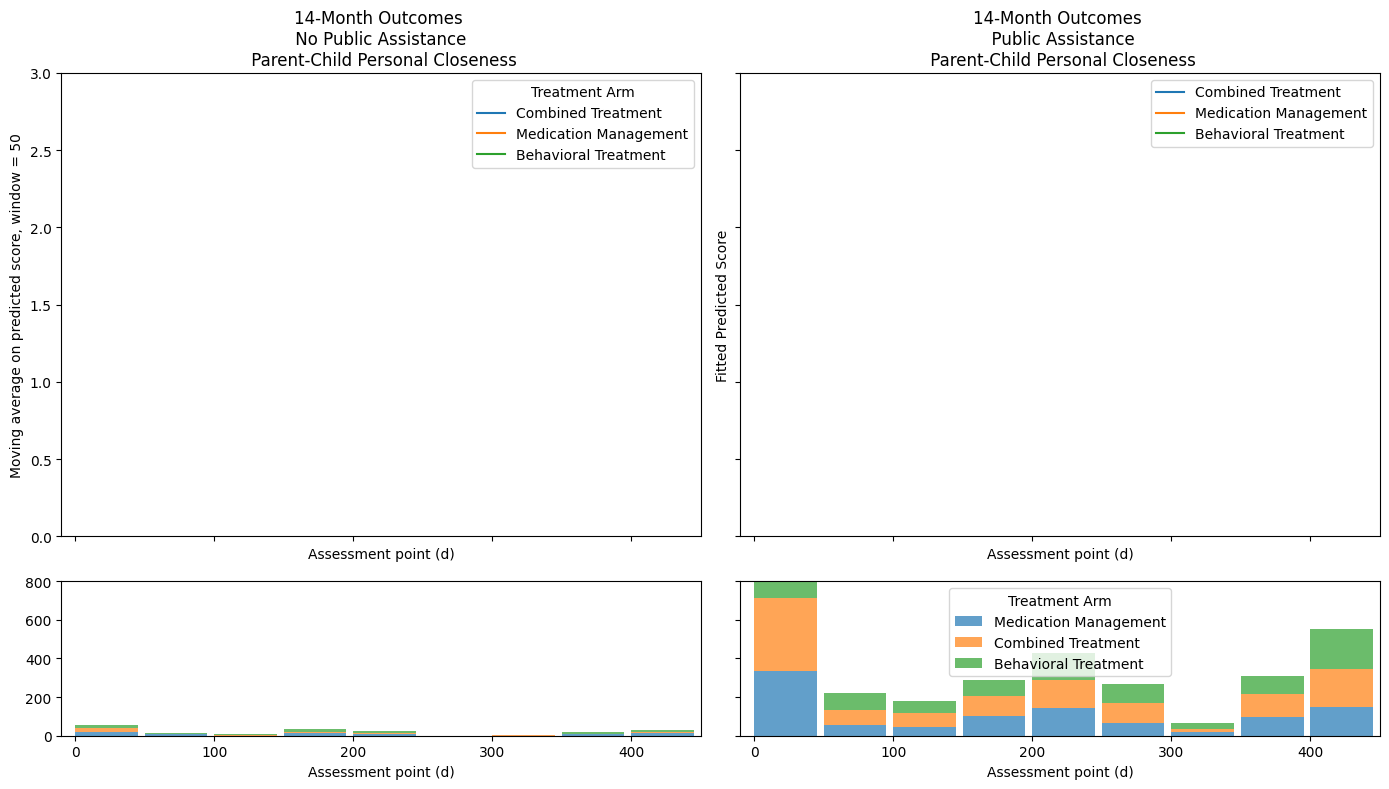

['predicted', 'd2dresp', 'snainatx', 'P']
d2dresp snainatx Parent
[1, 2, 3, 4, 5, 6]
0
SHAPE subset: (896,) SHAPE subset sorted (896,)
type moving average
SMOOTHED shape (896, 2)
0
SHAPE subset: (12,) SHAPE subset sorted (12,)
type moving average
SMOOTHED shape (12, 2)
LINE YES, LINE NO
      days_baseline  smoothed_value
145               0        1.552917
2255              0        1.531270
1038              0        1.511011
1391              0        1.571198
616               0        1.612308
...             ...             ...
761             448        0.872705
4162            448        0.872006
4218            448        0.869690
3112            449        0.873750
5018            450        0.872967

[896 rows x 2 columns]       days_baseline  smoothed_value
1064              0        1.518729
2467              0        1.482141
3899              0        1.494337
4762              0        1.482141
2468             69        1.452312
2469            131        1.415569
4763

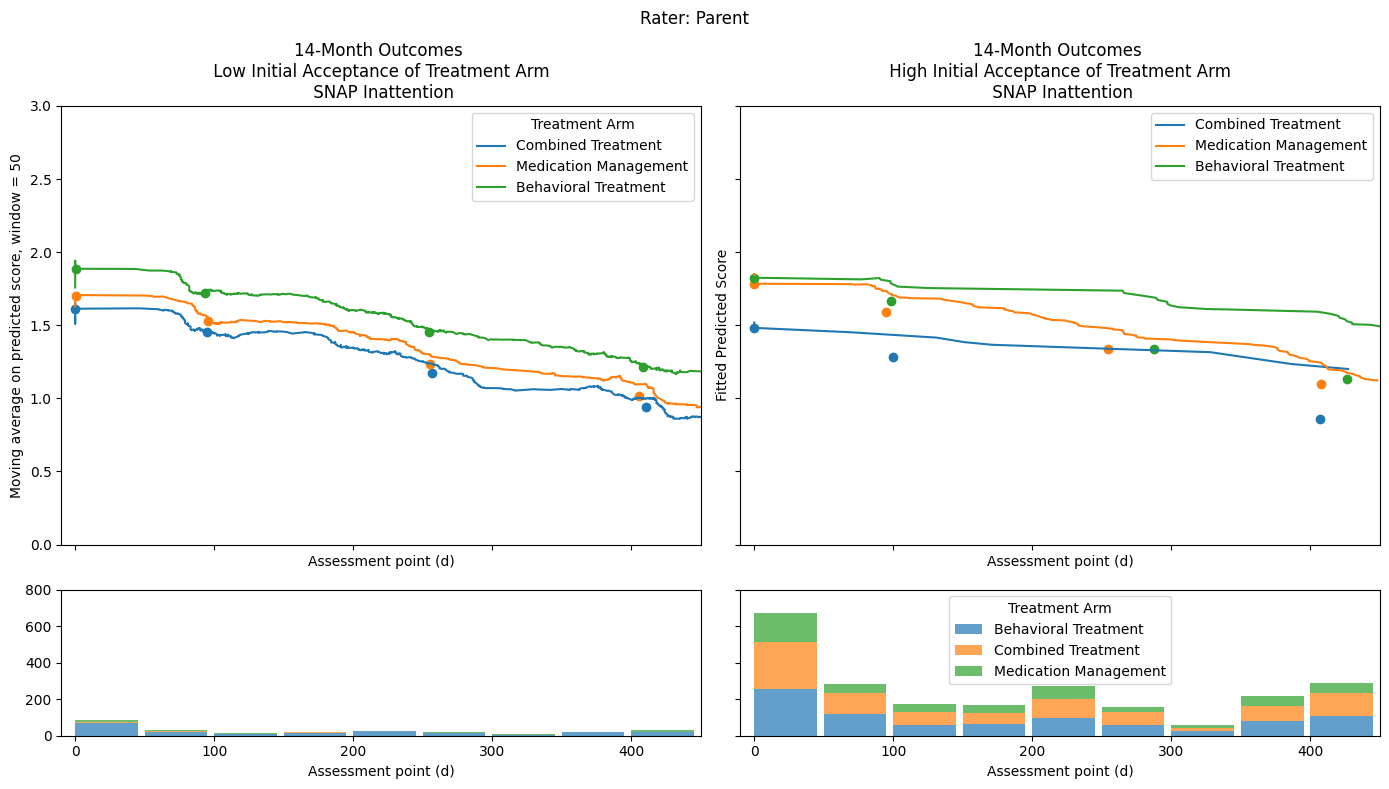

In [146]:
plot = True
save_path =None #Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_results = True
window = 50
type_plot= 'mov_av' # smooth #four_pnt


for col in cols_replication:
    items = col.split("_")
    print(items)
    var_mod = items[1]
    var_out = items[2]
    rater = raters_dict_rev[items[3]] if len(items) > 3 else None
    print(var_mod, var_out, rater)
    if var_out.startswith("sna"):
        data = data_dict["snap"]
    elif var_out.startswith("ss"):
        data = data_dict["ssrs"]
    elif var_out.startswith("pc"):data = data_dict["pc"]

    
    plot_RR_results(data, var_mod, var_out, med_values, type_plot=type_plot, window= window, timepoints_range=timepoints_range, trt_dict=trt_dict, rater=rater, xlim=xlim, ylim=ylim, show = plot, save_path=save_path)
    


In [ ]:
plot_RR_results(data, var_mod, var_out, med_values, type_plot=type_plot, window= window, timepoints_range=timepoints_range, trt_dict=trt_dict, rater=rater, xlim=xlim, ylim=ylim, show = plot, save_path=save_path)

In [86]:
data_dict['snap'].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted_cdorodd_snainatx_T',
       'predicted_cdorodd_snahypax_T', 'predicted_cdorodd_snaoddx_T',
       'predicted_anx_snainatx_T', 'predicted_anx_snahypax_T',
       'predicted_anx_snaoddx_T', 'predicted_demo61_snainatx_T',
       'predicted_demo61_snahypax_T', 'predicted_demo61_snaoddx_T',
       'predicted_hi_24_snainatx_T', 'predicted_hi_24_snahypax_T',
       'predicted_hi_24_snaoddx_T', 'predicted_d2dresp_snainatx_T',
       'predicted_d2dresp_snahypax_T', 'predicted_d2dresp_snaoddx_T',
       'predicted_sex_snainatx_T', 'predicted_sex_snahypax_T',
       'predicted_sex_snaoddx_T', 'predicted_cdorodd_snainatx_P',
       'predicted_cdorodd_snahypax_P', 'predicted_cdorodd_snaoddx_P',
       'predicted_anx_snainatx_P', 'predicted_anx_snahypax_P'

## 4 POINTS AV

In [60]:
def plot_4_point_av_fit(data, var_mod, var_out, med_values, window,  trt_dict , rater = None, show = True, save_path= None):
    print(show, save_path)
    ylim = [0,3]
    xlim = [-10, 450]
    pred_col_name= 'predicted_' + var_mod + '_' + var_out
    var_result = pred_col_name
    trtnames = data['trtname'].unique()
    pred_col_name= 'predicted_' + var_mod + '_' + var_out

    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

    values = med_values[var_mod]
    print(values)
    # Create subplots: 2 rows (1st row for polynomial fit, 2nd row for bar plot)
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]
        
        
    print(yes_mod.shape, no_mod.shape)
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    # Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
    for trt in trtnames:


        df_yes = yes_mod[yes_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        df_no = no_mod[no_mod['trtname'] == trt].dropna(subset=[pred_col_name])
        
        smoothed_yes = get_rolling_av(df_yes, pred_col_name, window)
        pnt_av = get_point_av(smoothed_yes, timepoints_range)
        
        smoothed_no = get_rolling_av(df_no, pred_col_name, window)
        pnt_av = get_point_av(smoothed_no, timepoints_range)
        x_fit_min = min(point_av_yes[:, 0].min(), point_av_yes[:, 0].min())
        x_fit_max = max(point_av_yes[:, 0].max(), point_av_no[:, 0].max())

        # Generate 100 evenly spaced points between the min and max values
        x_fit = np.linspace(x_fit_min, x_fit_max, 100)

        # Remove NaN and Infinite values
        point_av_no = point_av_no[~np.isnan(point_av_no).any(axis=1)]
        point_av_no = point_av_no[~np.isinf(point_av_no).any(axis=1)]
        point_av_yes = point_av_yes[~np.isnan(point_av_yes).any(axis=1)]
        point_av_yes = point_av_yes[~np.isinf(point_av_yes).any(axis=1)]

        # Ensure enough points for polynomial fitting
        if len(point_av_no) > 2 and len(point_av_yes) > 2:
            try:
                # Polynomial fit for 'yes'
                poly_fit_yes = np.polyfit(point_av_yes[:, 0], point_av_yes[:, 1], 2)
                poly_function_yes = np.poly1d(poly_fit_yes)
                y_fit_yes = poly_function_yes(x_fit)
                axes[0, 0].scatter(point_av_yes[:, 0], point_av_yes[:, 1], label=trt_dict[trt])
                axes[0, 0].plot(x_fit, y_fit_yes, linestyle='--', label=trt_dict[trt])
            except np.linalg.LinAlgError:
                print("Polynomial fit for 'yes' failed due to singular matrix")

            try:
                # Polynomial fit for 'no'
                poly_fit_no = np.polyfit(point_av_no[:, 0], point_av_no[:, 1], 2)
                poly_function_no = np.poly1d(poly_fit_no)
                y_fit_no = poly_function_no(x_fit)
                axes[0, 1].scatter(point_av_no[:, 0], point_av_no[:, 1], label=trt_dict[trt])
                axes[0, 1].plot(x_fit, y_fit_no, linestyle='--', label=trt_dict[trt])
            except np.linalg.LinAlgError:
                print("Polynomial fit for 'no' failed due to singular matrix")
        else:
            print("Not enough points for polynomial fit in treatment group:", trt)

            # Plot bar plot for the number of data points in the 'yes' condition (bottom left)
            #axes[1, 0].bar(time, n_yes, width=40, align='center', label=trt_dict[trt])
            
            # Plot bar plot for the number of data points in the 'no' condition (bottom right)
            #axes[1, 1].bar(time, n_no, width=40, align='center', label=trt_dict[trt])


    axes[0, 0].set_xlabel('Assessment point (d)')
    axes[0, 0].set_ylabel('Fitted Predicted Score')
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])
    # Add labels and titles to the subplots
    #axes[1, 0].set_title(title[1])
    #axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    #axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlabel('Assessment point (d)')
    axes[0, 1].set_ylabel('Fitted Predicted Score')
    axes[0, 1].legend()




    # Set xlim and ylim
    axes[0, 0].set_xlim(x_lim)
    axes[0, 1].set_xlim(x_lim)
    axes[1, 0].set_xlim(x_lim)
    axes[1, 1].set_xlim(x_lim)

    axes[0, 0].set_ylim(y_lim)
    axes[0, 1].set_ylim(y_lim)


    bins = timepoints  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No  mediator"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group

    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)


    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    if save_path is not None:
        folder_path = Path(save_path) / 'four_pt_fit'
        folder_path.mkdir(exist_ok=True)
        fig_name = var_result + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        print(folder_path)
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

## MOVING AV

In [43]:
def plot_moving_av(data, var_mod, var_out, med_values, window,  trt_dict , rater =None, show = True, save_path= None):
    ylim = [0,3]
    xlim = [-10, 450]
    pred_col_name= 'predicted_' + var_mod + '_' + var_out
    values = med_values[var_mod]    
    
    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
    
    type_plot_dict ={"poly_fit": "Polyniomial fit on four point average, degree 2", 
                 "mov_av": "Moving average on predicted score, window = {}".format(window),
                 "smooth": "Smoothed Predicted Score"}

    # get data for yes and no mediator condition 
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]

    # Create subplots (2 rows, 2 columns) with shared x-axis
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    if rater is not None: 
        plt.suptitle('Rater: ' + rater)
        
    # Plot for "No Anxiety" subgroup
    for trt in no_mod['trtname'].unique():
        print(trt)
        # Subset data by treatment group and sort by 'days_baseline'
        subset = no_mod[no_mod['trtname'] == trt]
        n = subset.shape[0]

        smoothed_df = get_rolling_av(subset, pred_col_name, window)
        point_av = get_point_av(smoothed_df, timepoints_range)

        axes[ 0, 0 ].scatter(point_av[:,0], point_av[:,1])
        axes[0, 0].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

    # Set labels, title, and limits
    axes[0, 0].set_xlabel('Days Baseline')
    axes[0, 0].set_ylabel(type_plot_dict[type_plot])
    axes[0, 0].legend(title='Treatment Arm')
    axes[0, 0].set_xlim(xlim)  # Set x-axis limits
    axes[0, 0].set_ylim(ylim)  # Set y-axis limits
    axes[0, 0].set_title(title[0])


    for trt in yes_mod['trtname'].unique():
        print(trt)
        # Subset data by treatment group and sort by 'days_baseline'
        subset = yes_mod[yes_mod['trtname'] == trt]
        n = subset.shape[0]
        
        smoothed_df = get_rolling_av(subset, pred_col_name, window)
        point_av = get_point_av(smoothed_df, timepoints_range)
        
        axes[ 0, 1].scatter(point_av[:,0], point_av[:,1])
            # Plot the line using the sorted 'days_baseline' and corresponding rolling mean
        axes[0, 1].plot(smoothed_df['days_baseline'], smoothed_df['smoothed_value'], label=trt_dict[trt] + ' (n = {})'.format(n))

    axes[0, 1].set_title(title[1])
    axes[0, 1].set_xlim(xlim)  # Set x-axis from 0 to 450
    axes[0, 1].set_ylim(ylim)  # Ensure y-axis is from 0 to 3

    ### Second row: Stacked bar plots for the number of data points colored by treatment group ###

    # Define bins for the time points (based on 'days_baseline')
    bins = np.linspace(0, 450, num=10)  # Adjust the number of bins as needed

    #Bar plot for "No Anxiety"
    trt_groups_no = no_mod['trtname'].unique()
    counts_by_trt_no = {trt: np.histogram(no_mod[no_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_no}

    # Initialize bottom for stacked bars
    bottom_no = np.zeros(len(bins)-1)

    # Plot the stacked bars for "No  mediator"
    for trt in trt_groups_no:
        counts = counts_by_trt_no[trt]
        axes[1, 0].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_no, label=trt_dict[trt], alpha=0.7)
        bottom_no += counts  # Update bottom for the next treatment group


    # Bar plot for "Anxiety"
    trt_groups_yes = yes_mod['trtname'].unique()
    counts_by_trt_yes = {trt: np.histogram(yes_mod[yes_mod['trtname'] == trt]['days_baseline'], bins=bins)[0] for trt in trt_groups_yes}

    # Initialize bottom for stacked bars
    bottom_yes = np.zeros(len(bins)-1)
    # Plot the stacked bars for "Anxiety"
    for trt in trt_groups_yes:
        counts = counts_by_trt_yes[trt]
        axes[1, 1].bar(bins[:-1], counts, width=45, align='edge', bottom=bottom_yes, label=trt_dict[trt], alpha=0.7)
        bottom_yes += counts  # Update bottom for the next treatment group

    axes[1, 0].set_ylabel('Number of Data Points')
    axes[1, 0].set_xlabel('Assessment point (d)')
    axes[1, 0].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 0].set_ylim([0,800])
    axes[1, 0].legend(title='Treatment Arm')

    axes[1, 1].set_xlabel('Assessment point (d)')
    axes[1, 1].set_xlim(xlim)  # Match x-axis to the upper plot
    axes[1, 1].set_ylim([0,800])  # Match x-axis to the upper plot
    axes[1, 1].legend(title='Treatment Arm')

    ## Save or Show the plot ###
    if save_path is not None:
        folder_path = Path(save_path) / 'mov_av'
        folder_path.mkdir(parents=True, exist_ok=True)
        fig_name = pred_col_name + '_' + str(rater[0]) + '.jpg' if rater is not None else var_result + '.jpg'
        plt.savefig(folder_path / fig_name, dpi=300)

    if show:
        plt.tight_layout()
        plt.show()

SNAP, SSRS
SNAP
SSRS
MASC
PC
[0, 1]
(421, 53)
type smoothed
(421,) (421,)
(421, 2)
(615, 53)
type smoothed
(615,) (615,)
(615, 2)
     days_baseline  smoothed_value
0              0.0        2.090011
1              0.0        2.090011
2              0.0        2.090011
3              0.0        2.090011
4              0.0        2.090011
..             ...             ...
416          446.0        0.684305
417          447.0        0.683014
418          448.0        0.681710
419          449.0        0.680388
420          450.0        0.679043

[421 rows x 2 columns]
(335, 53)
type smoothed
(335,) (335,)
(335, 2)
(603, 53)
type smoothed
(603,) (603,)
(603, 2)
     days_baseline  smoothed_value
0              0.0        2.239780
1              0.0        2.239780
2              0.0        2.239780
3              0.0        2.239780
4              0.0        2.239780
..             ...             ...
330          444.0        0.827456
331          445.0        0.822634
332          447.

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

True


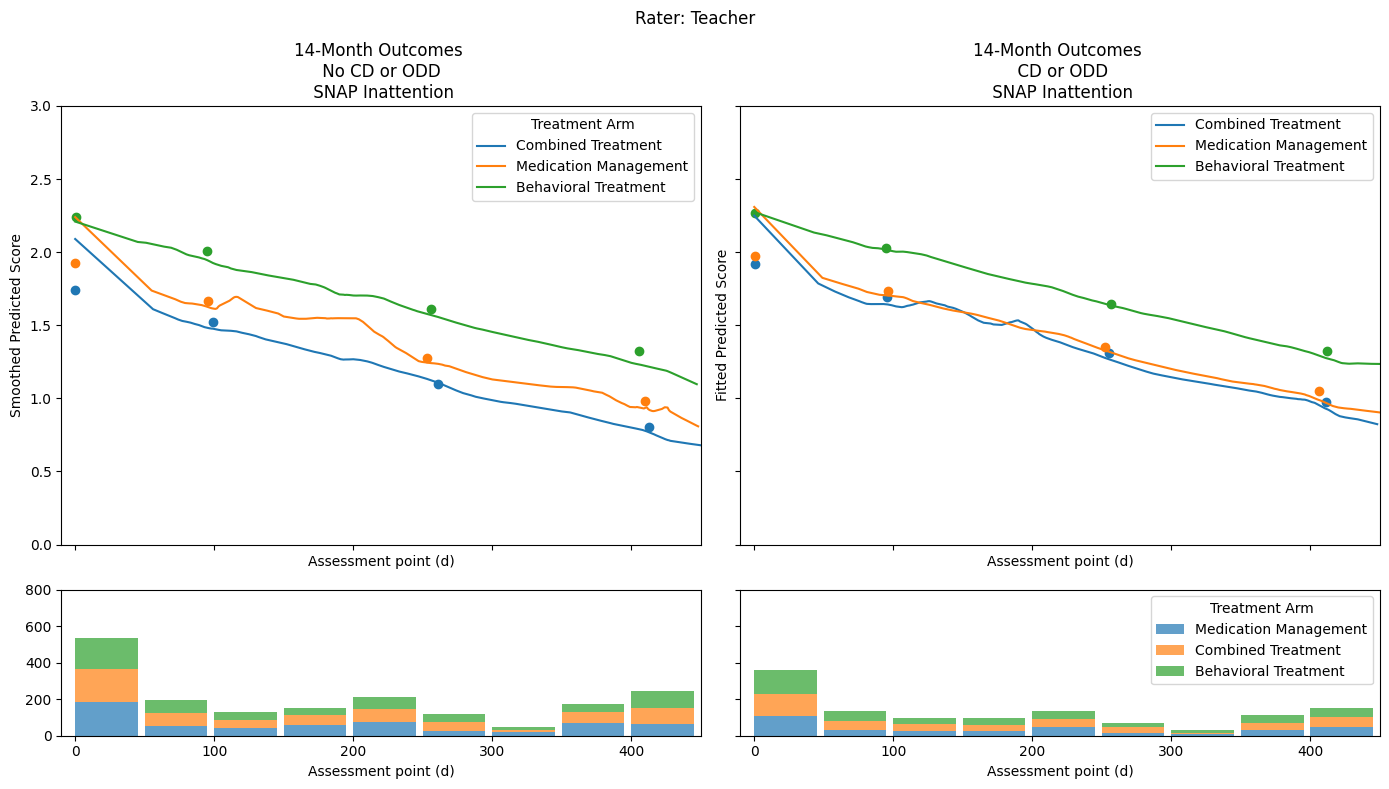

SNAP
SSRS
MASC
PC
[0, 1]
(421, 53)
type smoothed
(421,) (421,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(421, 2)
(615, 53)
type smoothed
(615,) (615,)
(615, 2)
     days_baseline  smoothed_value
0              0.0        1.695836
1              0.0        1.695836
2              0.0        1.695836
3              0.0        1.695836
4              0.0        1.695836
..             ...             ...
416          446.0        0.335071
417          447.0        0.333987
418          448.0        0.332889
419          449.0        0.331761
420          450.0        0.330592

[421 rows x 2 columns]
(335, 53)
type smoothed
(335,) (335,)
(335, 2)
(603, 53)
type smoothed
(603,) (603,)
(603, 2)
     days_baseline  smoothed_value
0              0.0        1.865648
1              0.0        1.865648
2              0.0        1.865648
3              0.0        1.865648
4              0.0        1.865648
..             ...             ...
330          444.0        0.494528
331          445.0        0.490132
332          447.0        0.481674
333          447.0        0.481674
334          448.0   

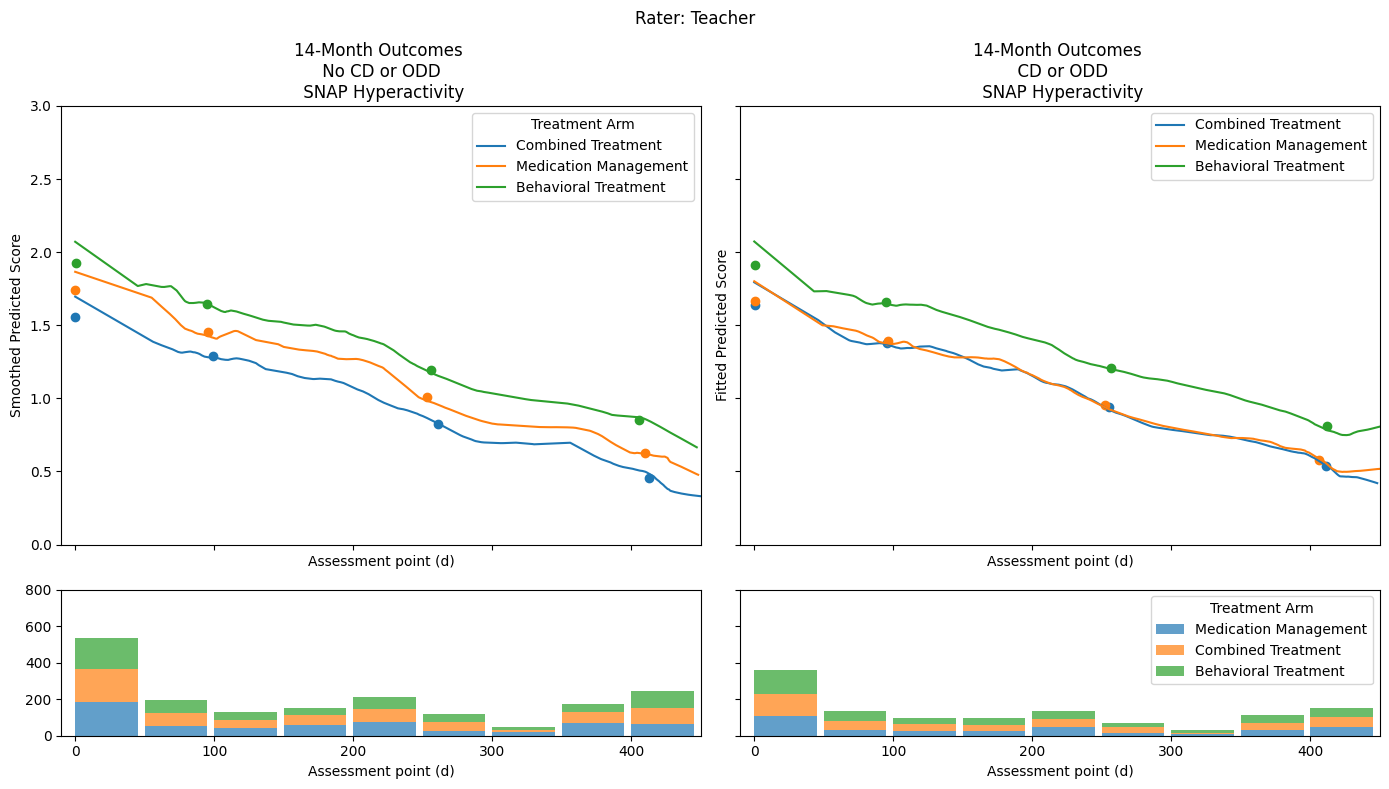

SNAP
SSRS
MASC
PC
[0, 1]
(421, 53)
type smoothed
(421,) (421,)
(421, 2)
(615, 53)
type smoothed
(615,) (615,)
(615, 2)
     days_baseline  smoothed_value
0              0.0        1.129838
1              0.0        1.129838
2              0.0        1.129838
3              0.0        1.129838
4              0.0        1.129838
..             ...             ...
416          446.0        0.545066
417          447.0        0.547292
418          448.0        0.549493
419          449.0        0.551648
420          450.0        0.553740

[421 rows x 2 columns]
(335, 53)
type smoothed
(335,) (335,)
(335, 2)
(603, 53)
type smoothed
(603,) (603,)
(603, 2)
     days_baseline  smoothed_value
0              0.0        1.241857
1              0.0        1.241857
2              0.0        1.241857
3              0.0        1.241857
4              0.0        1.241857
..             ...             ...
330          444.0        0.517309
331          445.0        0.512153
332          447.0        0.

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

True


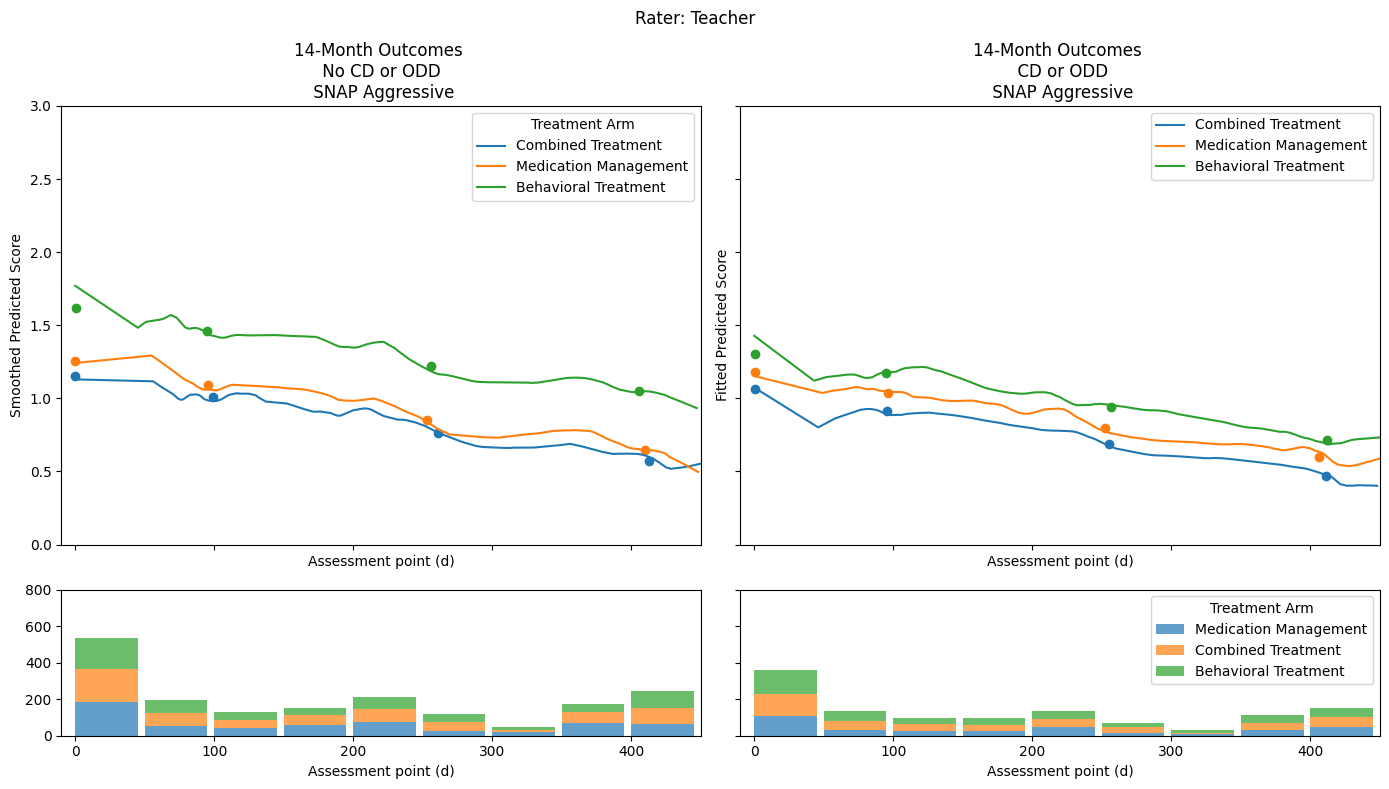

SNAP
SSRS
MASC
PC
[0, 1]
(340, 53)
type smoothed
(340,) (340,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(340, 2)
(737, 53)
type smoothed
(737,) (737,)
(737, 2)
     days_baseline  smoothed_value
0              0.0        2.017078
1              0.0        2.017078
2              0.0        2.017078
3              0.0        2.017078
4              0.0        2.017078
..             ...             ...
335          443.0        0.659316
336          443.0        0.659316
337          444.0        0.658104
338          447.0        0.654443
339          448.0        0.653203

[340 rows x 2 columns]
(322, 53)
type smoothed
(322,) (322,)
(322, 2)
(605, 53)
type smoothed
(605,) (605,)
(605, 2)
     days_baseline  smoothed_value
0              0.0        2.200908
1              0.0        2.200908
2              0.0        2.200908
3              0.0        2.200908
4              0.0        2.200908
..             ...             ...
317          440.0        0.947763
318          440.0        0.947763
319          440.0        0.947763
320          442.0        0.951615
321          448.0   

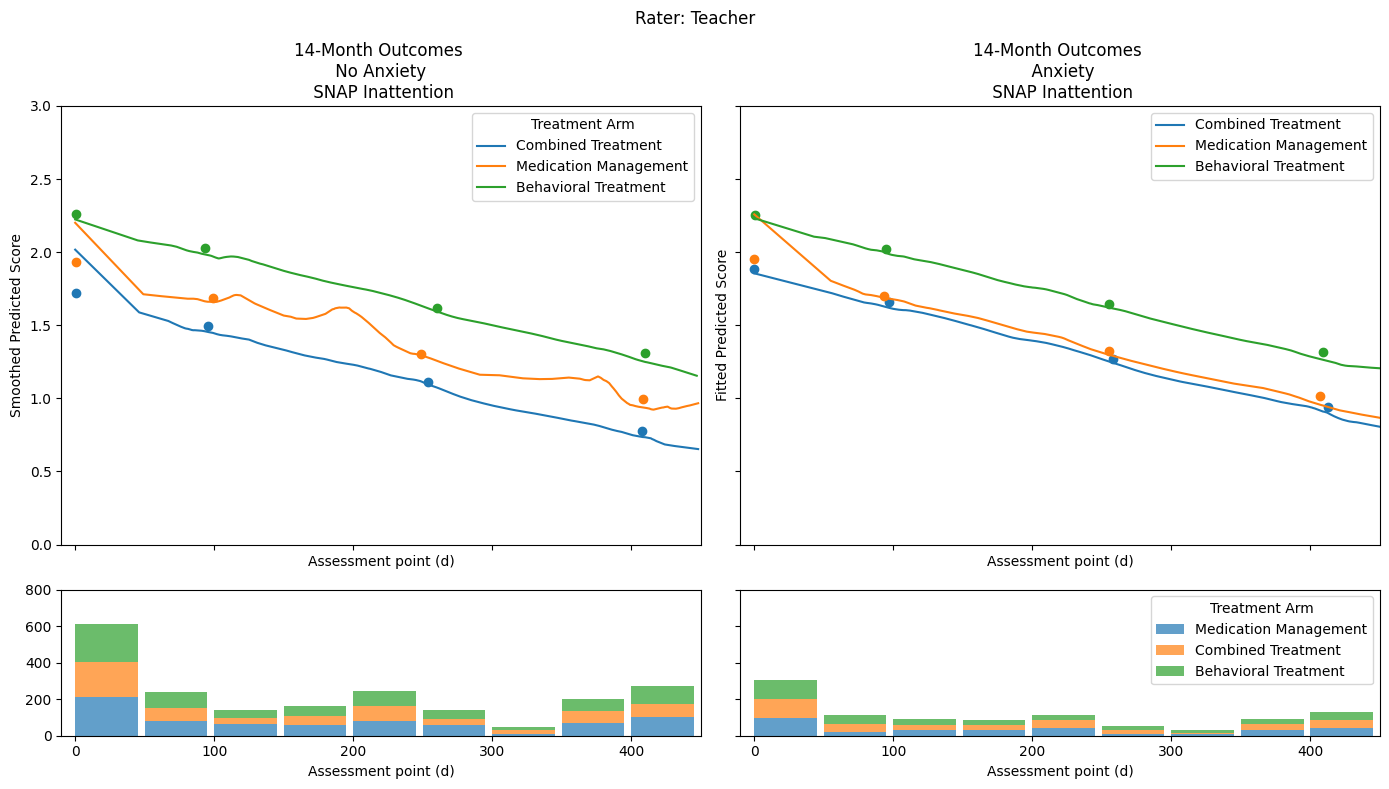

SNAP
SSRS
MASC
PC
[0, 1]
(340, 53)
type smoothed
(340,) (340,)
(340, 2)
(737, 53)
type smoothed
(737,) (737,)
(737, 2)
     days_baseline  smoothed_value
0              0.0        1.597611
1              0.0        1.597611
2              0.0        1.597611
3              0.0        1.597611
4              0.0        1.597611
..             ...             ...
335          443.0        0.295083
336          443.0        0.295083
337          444.0        0.293595
338          447.0        0.289293
339          448.0        0.287873

[340 rows x 2 columns]
(322, 53)
type smoothed
(322,) (322,)
(322, 2)
(605, 53)
type smoothed
(605,) (605,)
(605, 2)
     days_baseline  smoothed_value
0              0.0        1.631616
1              0.0        1.631616
2              0.0        1.631616
3              0.0        1.631616
4              0.0        1.631616
..             ...             ...
317          440.0        0.374902
318          440.0        0.374902
319          440.0        0.

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

True


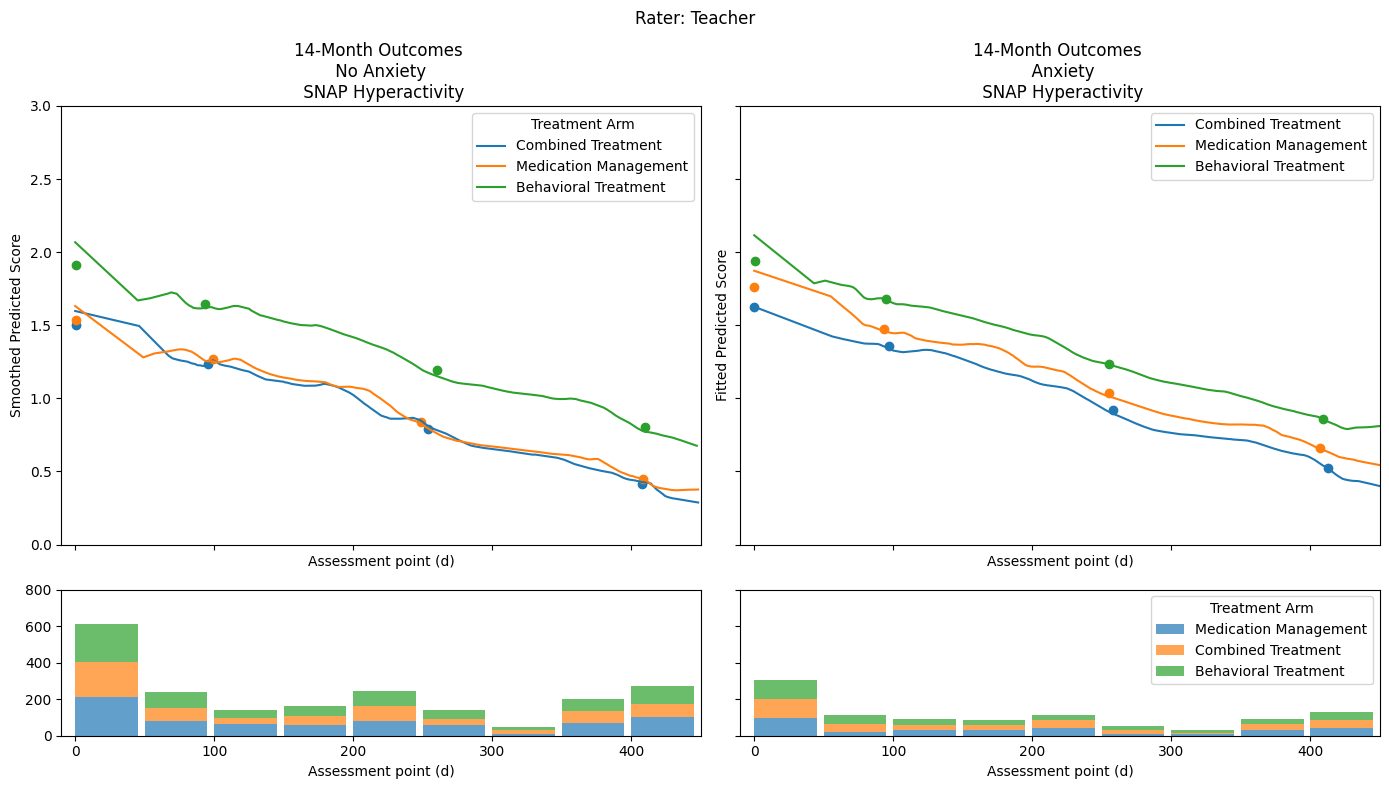

SNAP
SSRS
MASC
PC
[0, 1]
(340, 53)
type smoothed
(340,) (340,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(340, 2)
(737, 53)
type smoothed
(737,) (737,)
(737, 2)
     days_baseline  smoothed_value
0              0.0        1.085123
1              0.0        1.085123
2              0.0        1.085123
3              0.0        1.085123
4              0.0        1.085123
..             ...             ...
335          443.0        0.489098
336          443.0        0.489098
337          444.0        0.489567
338          447.0        0.491174
339          448.0        0.491749

[340 rows x 2 columns]
(322, 53)
type smoothed
(322,) (322,)
(322, 2)
(605, 53)
type smoothed
(605,) (605,)
(605, 2)
     days_baseline  smoothed_value
0              0.0        1.126948
1              0.0        1.126948
2              0.0        1.126948
3              0.0        1.126948
4              0.0        1.126948
..             ...             ...
317          440.0        0.502306
318          440.0        0.502306
319          440.0        0.502306
320          442.0        0.503661
321          448.0   

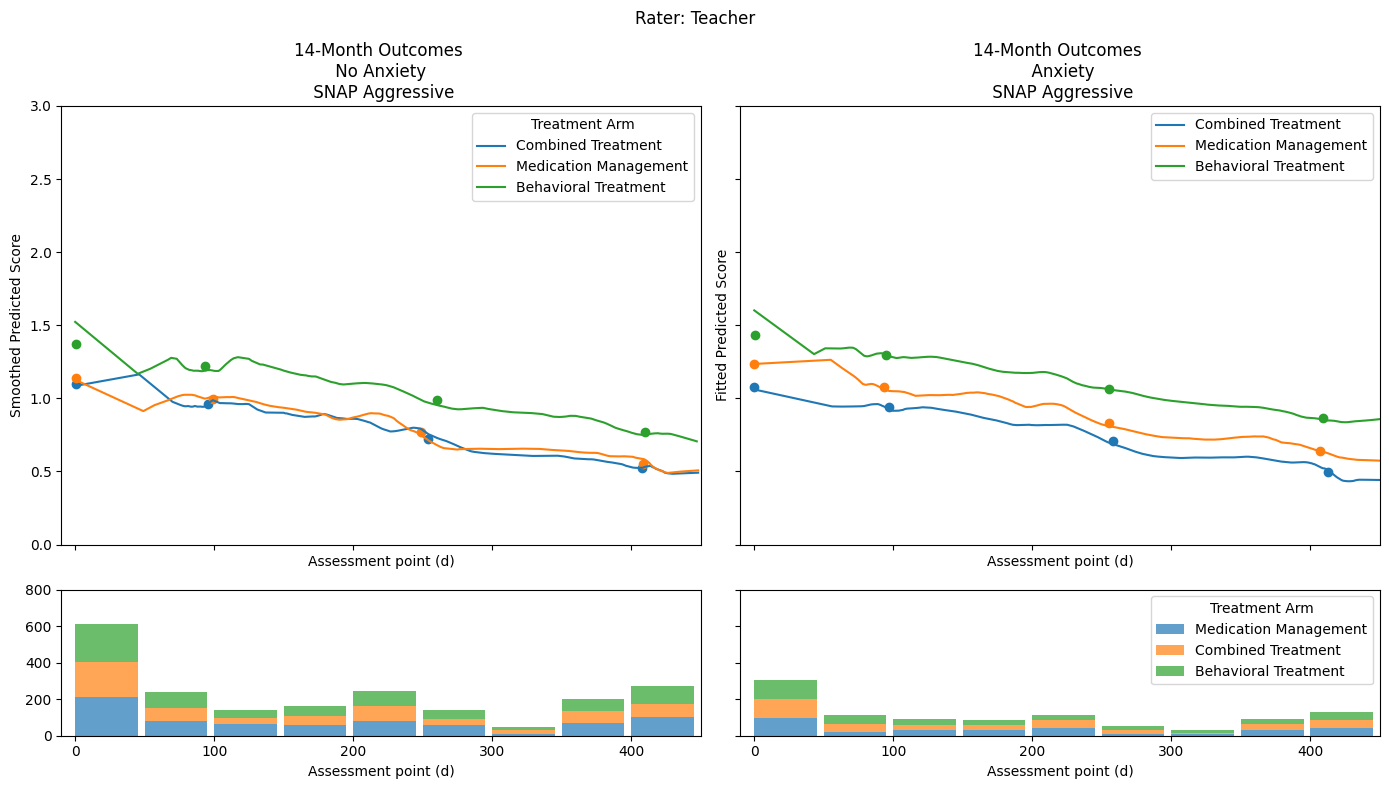

SNAP
SSRS
MASC
PC
[1, 2]
(997, 53)
type smoothed
(997,) (997,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(997, 2)
(49, 53)
type smoothed
(49,) (49,)
(49, 2)
     days_baseline  smoothed_value
0              0.0        2.149479
1              0.0        2.149479
2              0.0        2.149479
3              0.0        2.149479
4              0.0        2.149479
..             ...             ...
992          448.0        0.719023
993          448.0        0.719023
994          448.0        0.719023
995          449.0        0.716876
996          450.0        0.714697

[997 rows x 2 columns]
(816, 53)
type smoothed
(816,) (816,)
(816, 2)
(42, 53)
type smoothed
(42,) (42,)
(42, 2)
     days_baseline  smoothed_value
0              0.0        2.260402
1              0.0        2.260402
2              0.0        2.260402
3              0.0        2.260402
4              0.0        2.260402
..             ...             ...
811          447.0        0.819136
812          447.0        0.819136
813          447.0        0.819136
814          448.0        0.816500
815          448.0        0.8

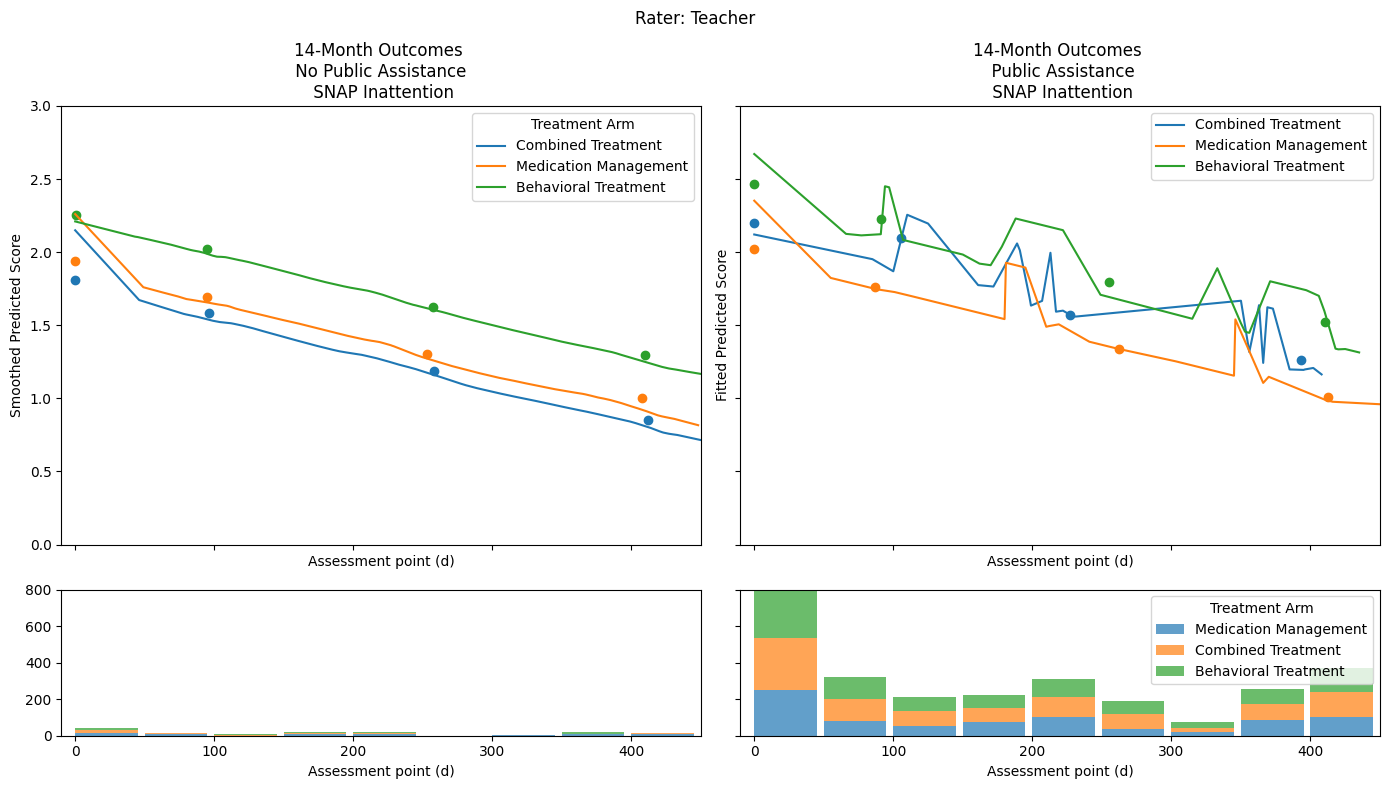

SNAP
SSRS
MASC
PC
[1, 2]
(997, 53)
type smoothed
(997,) (997,)
(997, 2)
(49, 53)
type smoothed
(49,) (49,)
(49, 2)
     days_baseline  smoothed_value
0              0.0        1.703286
1              0.0        1.703286
2              0.0        1.703286
3              0.0        1.703286
4              0.0        1.703286
..             ...             ...
992          448.0        0.337098
993          448.0        0.337098
994          448.0        0.337098
995          449.0        0.334598
996          450.0        0.332028

[997 rows x 2 columns]
(816, 53)
type smoothed
(816,) (816,)
(816, 2)
(42, 53)
type smoothed
(42,) (42,)
(42, 2)
     days_baseline  smoothed_value
0              0.0        1.789730
1              0.0        1.789730
2              0.0        1.789730
3              0.0        1.789730
4              0.0        1.789730
..             ...             ...
811          447.0        0.459496
812          447.0        0.459496
813          447.0        0.459496
8

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

True


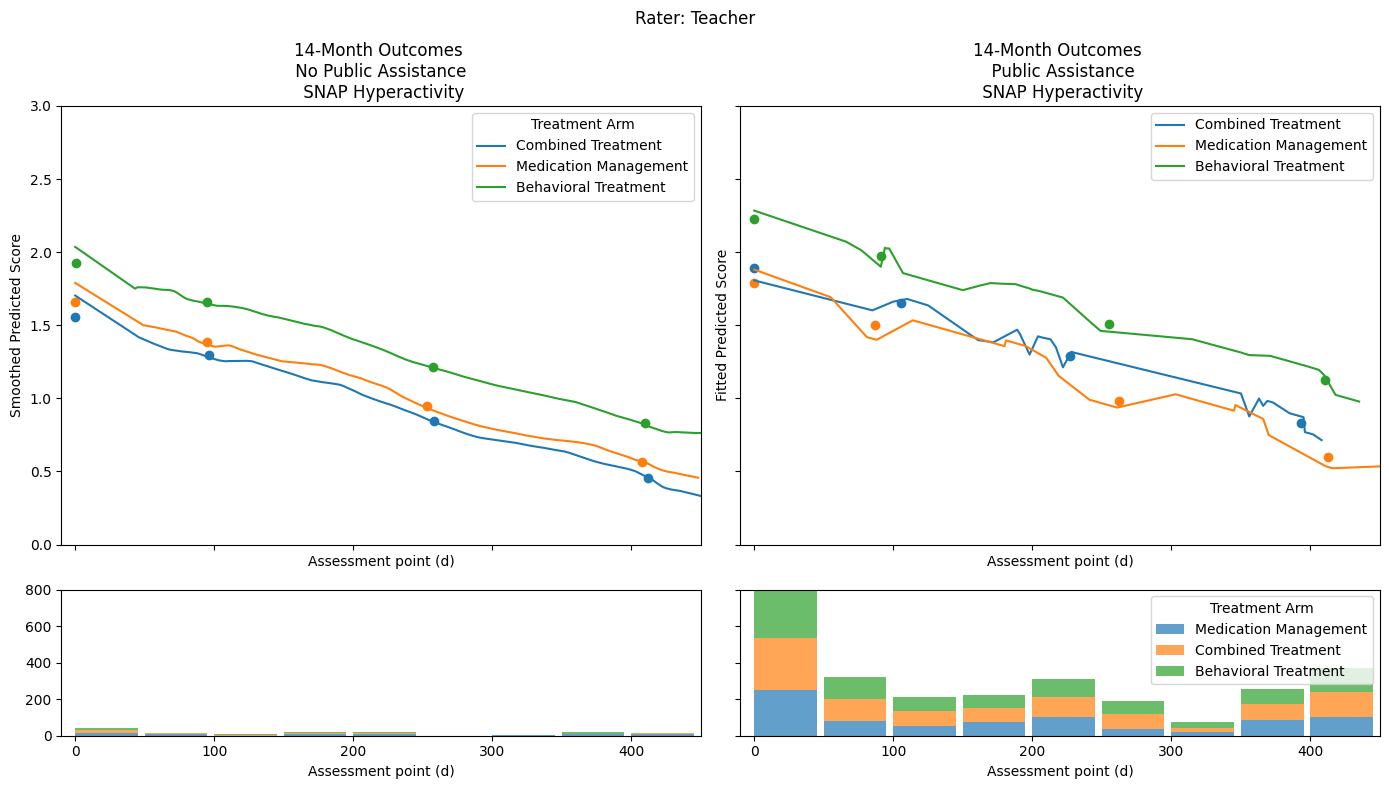

SNAP
SSRS
MASC
PC
[1, 2]
(997, 53)
type smoothed
(997,) (997,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(997, 2)
(49, 53)
type smoothed
(49,) (49,)
(49, 2)
     days_baseline  smoothed_value
0              0.0        1.103739
1              0.0        1.103739
2              0.0        1.103739
3              0.0        1.103739
4              0.0        1.103739
..             ...             ...
992          448.0        0.435957
993          448.0        0.435957
994          448.0        0.435957
995          449.0        0.435493
996          450.0        0.434941

[997 rows x 2 columns]
(816, 53)
type smoothed
(816,) (816,)
(816, 2)
(42, 53)
type smoothed
(42,) (42,)
(42, 2)
     days_baseline  smoothed_value
0              0.0        1.205028
1              0.0        1.205028
2              0.0        1.205028
3              0.0        1.205028
4              0.0        1.205028
..             ...             ...
811          447.0        0.525659
812          447.0        0.525659
813          447.0        0.525659
814          448.0        0.524069
815          448.0        0.5

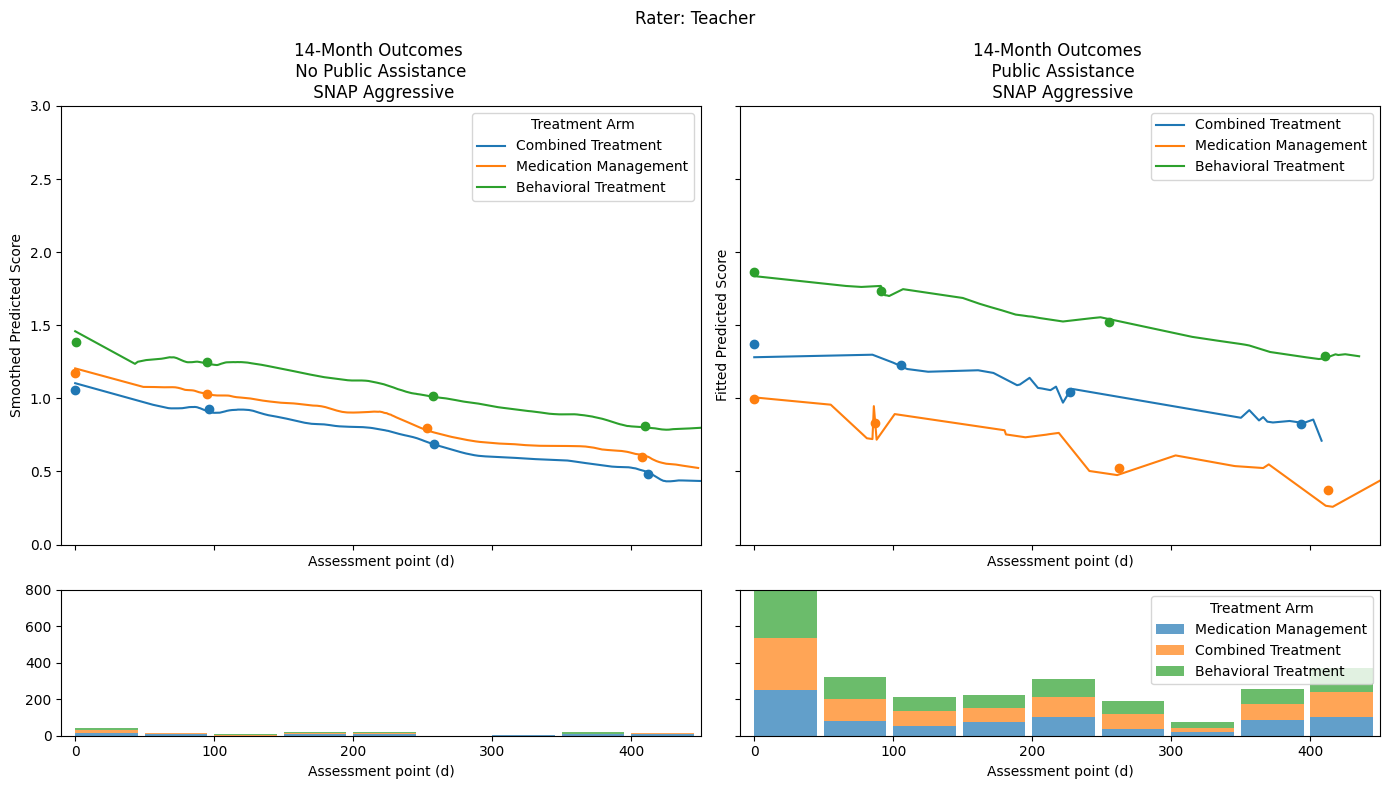

SNAP
SSRS
MASC
PC
[1, 2]
(87, 53)
type smoothed
(87,) (87,)
(87, 2)
(30, 53)
type smoothed
(30,) (30,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(30, 2)
    days_baseline  smoothed_value
0             0.0        1.875726
1             0.0        1.875726
2             0.0        1.875726
3             0.0        1.875726
4             0.0        1.875726
..            ...             ...
82          416.0        0.804185
83          422.0        0.854567
84          427.0        0.916394
85          443.0        0.776029
86          444.0        0.769297

[87 rows x 2 columns]
(109, 53)
type smoothed
(109,) (109,)
(109, 2)
(46, 53)
type smoothed
(46,) (46,)
(46, 2)
     days_baseline  smoothed_value
0              0.0        1.708252
1              0.0        1.708252
2              0.0        1.708252
3              0.0        1.708252
4              0.0        1.708252
..             ...             ...
104          423.0        0.616379
105          423.0        0.616379
106          437.0        0.830417
107          437.0        0.830417
108          437.0        0.830417

[109 rows x 2 columns]
(49, 53)
type smoothed
(49,

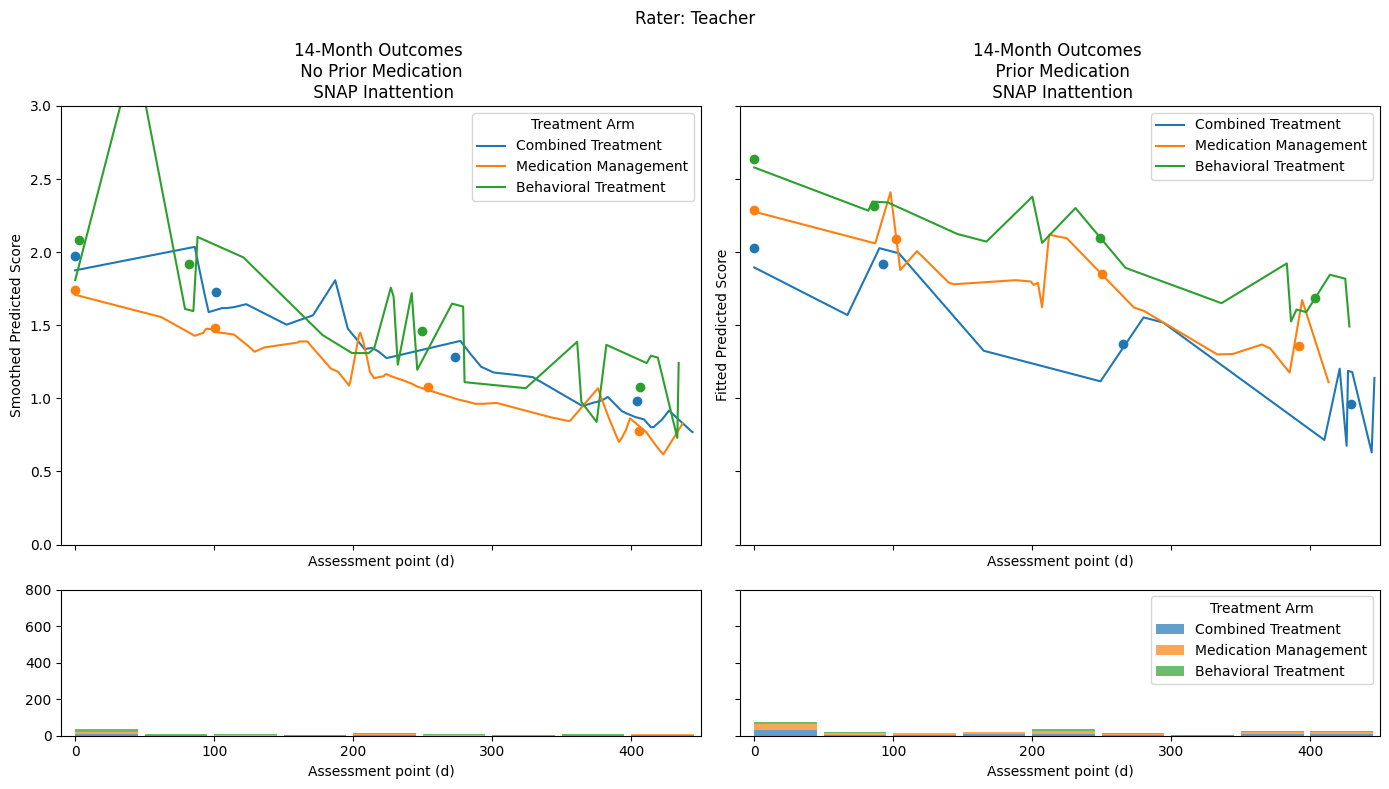

SNAP
SSRS
MASC
PC
[1, 2]
(87, 53)
type smoothed
(87,) (87,)
(87, 2)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(30, 53)
type smoothed
(30,) (30,)
(30, 2)
    days_baseline  smoothed_value
0             0.0        1.952075
1             0.0        1.952075
2             0.0        1.952075
3             0.0        1.952075
4             0.0        1.952075
..            ...             ...
82          416.0        0.662207
83          422.0        0.761409
84          427.0        0.855770
85          443.0        0.642530
86          444.0        0.629768

[87 rows x 2 columns]
(109, 53)
type smoothed
(109,) (109,)
(109, 2)
(46, 53)
type smoothed
(46,) (46,)
(46, 2)
     days_baseline  smoothed_value
0              0.0        1.886694
1              0.0        1.886694
2              0.0        1.886694
3              0.0        1.886694
4              0.0        1.886694
..             ...             ...
104          423.0        0.393687
105          423.0        0.393687
106          437.0        0.420794
107          437.0        0.420794
108          437.0        0.420794

[109 rows x 2 c

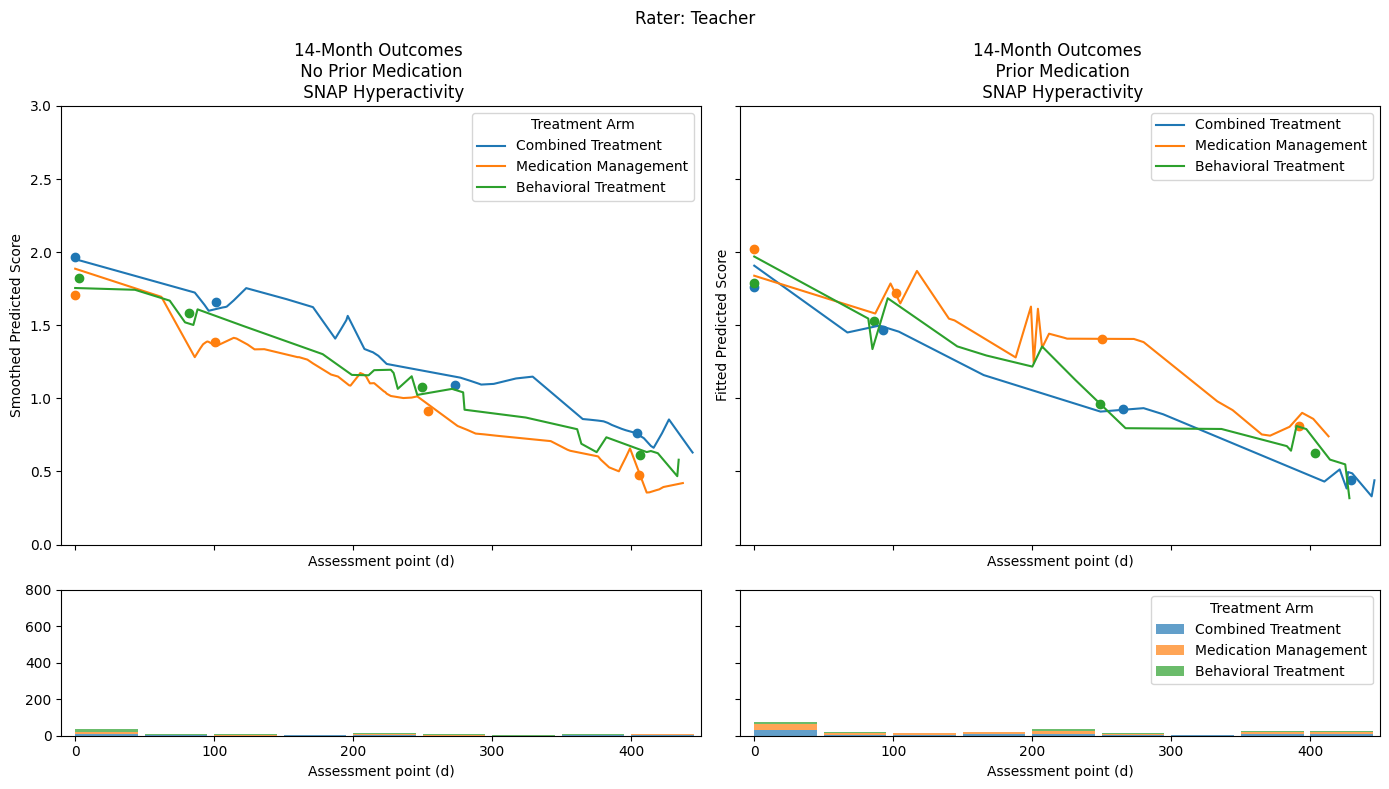

SNAP
SSRS
MASC
PC
[1, 2]
(87, 53)
type smoothed
(87,) (87,)
(87, 2)
(30, 53)
type smoothed
(30,) (30,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(30, 2)
    days_baseline  smoothed_value
0             0.0        1.087065
1             0.0        1.087065
2             0.0        1.087065
3             0.0        1.087065
4             0.0        1.087065
..            ...             ...
82          416.0        0.318605
83          422.0        0.366370
84          427.0        0.416181
85          443.0        0.349497
86          444.0        0.345705

[87 rows x 2 columns]
(109, 53)
type smoothed
(109,) (109,)
(109, 2)
(46, 53)
type smoothed
(46,) (46,)
(46, 2)
     days_baseline  smoothed_value
0              0.0        1.355877
1              0.0        1.355877
2              0.0        1.355877
3              0.0        1.355877
4              0.0        1.355877
..             ...             ...
104          423.0        0.475309
105          423.0        0.475309
106          437.0        0.334553
107          437.0        0.334553
108          437.0        0.334553

[109 rows x 2 columns]
(49, 53)
type smoothed
(49,

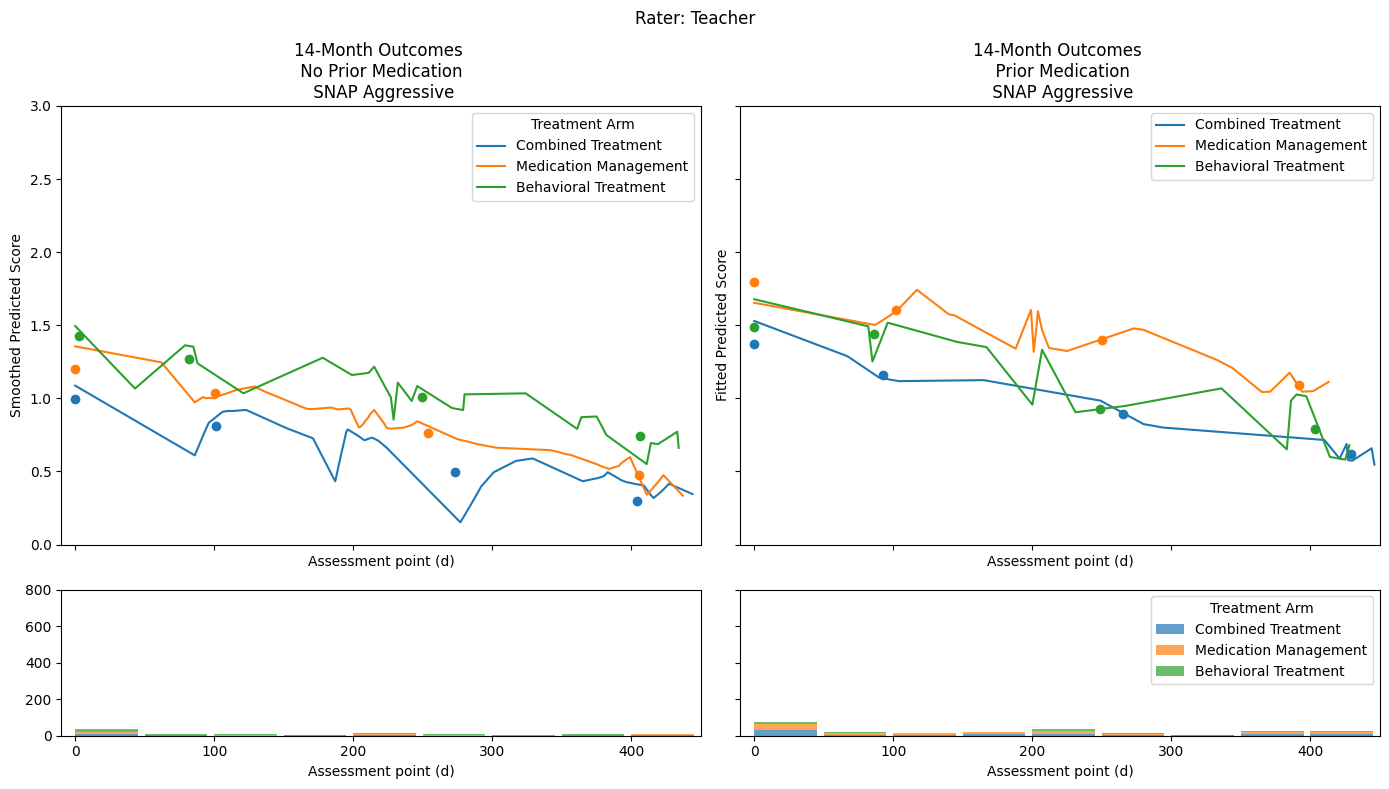

SNAP
SSRS
MASC
PC
[1, 2, 3, 4, 5, 6]
(896, 53)
type smoothed
(896,) (896,)


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid val

(896, 2)
(12, 53)
type smoothed
(12,) (12,)
(12, 2)
     days_baseline  smoothed_value
0              0.0        1.711886
1              0.0        1.711886
2              0.0        1.711886
3              0.0        1.711886
4              0.0        1.711886
..             ...             ...
891          448.0        0.747153
892          448.0        0.747153
893          448.0        0.747153
894          449.0        0.745462
895          450.0        0.743749

[896 rows x 2 columns]
(523, 53)
type smoothed
(523,) (523,)
(523, 2)
(205, 53)
type smoothed
(205,) (205,)
(205, 2)
     days_baseline  smoothed_value
0              0.0        1.817941
1              0.0        1.817941
2              0.0        1.817941
3              0.0        1.817941
4              0.0        1.817941
..             ...             ...
518          447.0        0.833019
519          447.0        0.833019
520          447.0        0.833019
521          448.0        0.831810
522          450.0       

OSError: [Errno 28] No space left on device

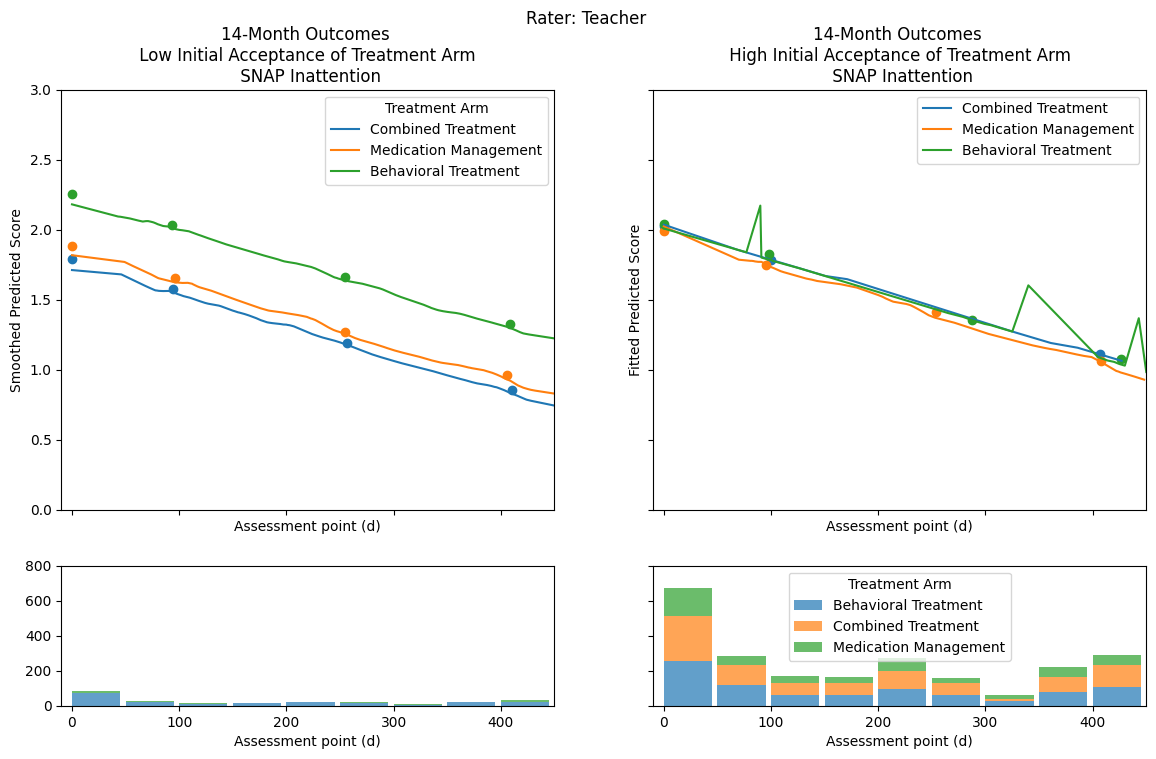

In [104]:
plot = True
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_results = True
window = 50
type_plot= 'smooth' # smooth #four_pnt




for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                
                if extract_results:
                    extract_prediction(results, data_dict, to_plot)
                
                
                plot_RR_results(data, var_mod, var_out, med_values, type_plot=type_plot, window= window, timepoints_range=timepoints_range, trt_dict=trt_dict, rater=rater, xlim=xlim, ylim=ylim, show=plot, save_path=save_path)


    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
                
            if extract_results:
                extract_prediction(results, data_dict, to_plot)
                
                
            plot_RR_results(data, var_mod, var_out, med_values, type_plot=type_plot, window= window, timepoints_range=timepoints_range, trt_dict=trt_dict, rater=rater, xlim=xlim, ylim=ylim, show=plot, save_path=save_path)


In [92]:
results

{'snap': {'Teacher': {'cdorodd_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87fc66fbe0>,
   'cdorodd_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cc800ca0>,
   'cdorodd_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87ca98c2b0>,
   'anx_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87f95620b0>,
   'anx_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87f9563c70>,
   'anx_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87f9563ac0>,
   'demo61_snainatx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cab83610>,
   'demo61_snahypax': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cab83490>,
   'demo61_snaoddx': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x7f87cabdf220>,
   'hi_24_snainatx': <stats

In [110]:
def extract_prediction(results, data_dict):
    # extract predicted datapoints for all questionnaires
    for qst in to_plot:
        if qst == 'snap' or qst == 'ssrs':
            print(qst.upper())
            for rater in raters:
                for var_result in results[qst][rater].keys():    
                    result = results[qst][rater][var_result]
                    #print(result)
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' +  str(var_result) +'_' + str(rater[0])] = result.predict(data) #
                    
        elif qst == 'masc' or qst == 'pc':    
            print(qst.upper())       
            for var_result in results[qst].keys():
                data = data_dict[qst]
                result = results[qst][var_result]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) 
                
                
def get_point_av(df, pred_col_name, timepoints_range):
    df.sort_values('days_baseline')
    subset = df[['days_baseline', pred_col_name]]
    point_av = np.array([ subset[subset['days_baseline'].isin(range(range_t[0], range_t[1]))].mean(axis = 0) for range_t in timepoints_range])
    return point_av 

In [111]:
extract_prediction(results, data_dict)

SNAP
SSRS
MASC
PC


In [141]:
data = data_dict['snap']
col_name = 'predicted_demo61_snaoddx_P'
data[col_name]


(3033,)

In [143]:

test_ptn_av = get_point_av(data, col_name, timepoints_range)

In [154]:

line = extract_line_plot(data, pred_col_name=col_name, type_plot='four_pnt_fit',pnt_av= test_ptn_av, window=50)
print(line)



type four point polynomial fit
[1.26890409 1.26340478 1.25792662 1.25246959 1.24703369 1.24161893
 1.23622531 1.23085282 1.22550147 1.22017126 1.21486218 1.20957423
 1.20430743 1.19906175 1.19383722 1.18863382 1.18345156 1.17829043
 1.17315044 1.16803158 1.16293386 1.15785727 1.15280183 1.14776751
 1.14275434 1.1377623  1.13279139 1.12784162 1.12291299 1.11800549
 1.11311913 1.1082539  1.10340981 1.09858686 1.09378504 1.08900436
 1.08424481 1.0795064  1.07478913 1.07009299 1.06541799 1.06076412
 1.05613139 1.0515198  1.04692934 1.04236002 1.03781183 1.03328478
 1.02877886 1.02429408 1.01983044 1.01538793 1.01096656 1.00656632
 1.00218722 0.99782926 0.99349243 0.98917674 0.98488218 0.98060876
 0.97635648 0.97212533 0.96791532 0.96372644 0.9595587  0.95541209
 0.95128662 0.94718229 0.94309909 0.93903703 0.9349961  0.93097631
 0.92697766 0.92300014 0.91904376 0.91510851 0.9111944  0.90730143
 0.90342959 0.89957889 0.89574932 0.89194089 0.8881536  0.88438744
 0.88064241 0.87691853 0.873215

In [126]:
col_name

'predicted_demo61_snaoddx_P'

In [ ]:
def plot_RR_mediators(data, var_mod, var_out, plot_type, med_values, timepoints_range, window,  trt_dict ,xlim, ylim,  rater = None, show = True, save_path= None):
    
    pred_col_name= 'predicted_' + var_mod + '_' + var_out

    trtnames = data['trtname'].unique()

    title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]), 
                '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]

    values = med_values[var_mod]
    
    if var_mod == 'd2dresp':
        no_mod = data[(data[var_mod].isin(values[:2])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod].isin(values[2:])) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
    else:
        no_mod = data[(data[var_mod] == values[0]) & (data['days_baseline'] >= -window) & (data['days_baseline'] <= 450)]
        yes_mod = data[(data[var_mod] == values[1]) & (data['days_baseline'] >=-window) & (data['days_baseline'] <= 450)]
        
        
    print(yes_mod.shape, no_mod.shape)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    if rater is not None: 
        plt.suptitle('Rater: ' + rater)

    # Loop over each treatment name and plot both the 'yes' and 'no' condition in separate subplots
    for trt in trtnames:
        yes_mod = yes_mod.sort_values('days_baseline')
        no_mod = no_mod.sort_values('days_baseline')
        four_point_av_yes = get_point_av(yes_mod, pred_col_name, timepoints_range)

In [119]:
timepoints_range

[[-50, 50], [40, 140], [220, 320], [370, 470]]

In [122]:
data_dict['snap'].keys()

Index(['Unnamed: 0', 'src_subject_id', 'interview_date', 'interview_age',
       'sex', 'snainatx', 'snahypax', 'snaoddx', 'days_baseline', 'site',
       'version_form', 'trtname', 'cdorodd', 'anx', 'hi_24', 'demo61',
       'd2dresp', 'predicted_cdorodd_snainatx_T',
       'predicted_cdorodd_snahypax_T', 'predicted_cdorodd_snaoddx_T',
       'predicted_anx_snainatx_T', 'predicted_anx_snahypax_T',
       'predicted_anx_snaoddx_T', 'predicted_demo61_snainatx_T',
       'predicted_demo61_snahypax_T', 'predicted_demo61_snaoddx_T',
       'predicted_hi_24_snainatx_T', 'predicted_hi_24_snahypax_T',
       'predicted_hi_24_snaoddx_T', 'predicted_d2dresp_snainatx_T',
       'predicted_d2dresp_snahypax_T', 'predicted_d2dresp_snaoddx_T',
       'predicted_sex_snainatx_T', 'predicted_sex_snahypax_T',
       'predicted_sex_snaoddx_T', 'predicted_cdorodd_snainatx_P',
       'predicted_cdorodd_snahypax_P', 'predicted_cdorodd_snaoddx_P',
       'predicted_anx_snainatx_P', 'predicted_anx_snahypax_P'

In [123]:
test = data_dict['snap']
col_name = 'predicted_demo61_snaoddx_P'



In [124]:
get_point_av(test, col_name, timepoints_range)

array([[1.96774194e-01, 1.26622979e+00],
       [9.55238095e+01, 1.15402220e+00],
       [2.55460465e+02, 9.67050676e-01],
       [4.13035556e+02, 8.28304041e-01]])

In [ ]:
plot = False
save_path =  None #Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_prediction = False
window = 30
plot_type= 'mov_av' # smooth #four_pnt


for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                
                if extract_prediction:
                    extract_prediction(results, data_dict)
                
                if plot_type == 'mov_av' : 
                    plot_moving_av(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                elif plot_type == 'smooth' : 
                    plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)
                elif plot_type == 'four_pt_fit':
                    plot_4_point_av_fit(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                    


    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
            if extract_results:
                result = result[var_result]
                data = data_dict[qst]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 

            if plot_type == 'mov_av' : 
                print('MOV AV')
                print(save_path)
                plot_moving_av(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
            elif plot_type == "smooth":
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, show= False, save_path=save_path)
            elif plot_type == 'four_pt_fit':
                plot_4_point_av_fit(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  


In [ ]:
plot = False
save_path = Path('/Users/alina/Desktop/MIT/code/data/output/figures/mediator_regression_14months')
to_plot = qsts
extract_results = True
window = 50
plot_type= 'smoothß' # smooth #four_pnt


for qst in to_plot:
    if qst == 'snap' or qst == 'ssrs':
        print('SNAP, SSRS')
        for rater in raters:
            for key in results[qst][rater].keys():

                if key.startswith('hi'):
                    var_mod = split_on_occurrence(key, '_', 2)[0]
                    var_out= split_on_occurrence(key, '_', 2)[1]
                else: 
                    var_mod = key.split('_')[0]
                    var_out =  key.split('_')[1]

                title = [rater + '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 

                data = data_dict[qst]
                result = results[qst][rater]

                
                var_result = var_mod + '_' + var_out

                title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
                values = med_values[var_mod]
                
                if extract_results:
                    result = result[var_result]
                    data = data_dict[qst]
                    data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 
                
                
                if plot_type == 'mov_av' : 
                    plot_moving_av(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                elif plot_type == 'smooth' : 
                    plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, save_path=save_path)
                elif plot_type == 'four_pt_fit':
                    plot_4_point_av_fit(data, var_mod, var_out, med_values, window, trt_dict, rater = rater, show = plot, save_path= None)
                    


    else: 
        print('MASC; PC')
        for key in results[qst].keys():
            print(qst)
            if key.startswith('hi'):
                var_mod = split_on_occurrence(key, '_', 2)[0]
                var_out= split_on_occurrence(key, '_', 2)[1]
            elif 'masc' in key:
                var_mod = split_on_occurrence(key, '_', 1)[0]
                var_out= split_on_occurrence(key, '_', 1)[1]
            else:
                var_mod = key.split('_')[0]
                var_out =  key.split('_')[1]
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])] 
            data = data_dict[qst]
            result = results[qst]

            
            var_result = var_mod + '_' + var_out
            title = ['14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][0], outcomes_dict_fig[var_out]) , '14-Month Outcomes \n {} \n {}'.format(med_dict_fig[var_mod][1], outcomes_dict_fig[var_out])]
            values = med_values[var_mod]
            if extract_results:
                result = result[var_result]
                data = data_dict[qst]
                data_dict[qst]['predicted_' + str(var_result)] = result.predict(data) #put teh result in original dataframe for later access 

            if plot_type == 'mov_av' : 
                print('MOV AV')
                print(save_path)
                plot_moving_av(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
            elif plot_type == "smooth":
                plot_RR_curves_med_mod_smooth(data=data, results=result, var_mod= var_mod, var_out=var_out, outcomes_dict_fig=outcomes_dict_fig, med_dict_fig=med_dict_fig, med_values=med_values, xlim=(-10,450), ylim=ylim_dict[qst], rater = rater, show= False, save_path=save_path)
            elif plot_type == 'four_pt_fit':
                plot_4_point_av_fit(data= data, var_mod=var_mod, var_out=var_out,med_values= med_values,window= window,trt_dict= trt_dict, rater = rater, show = plot, save_path= save_path)  
